In [4]:
import numpy as np

def probability(k, phi, p, tol=1e-12):
    """
    k: 測定基底の値（0 <= k < 2^p）
    phi: 位相（実数）
    p: 制御ビット数（整数）
    tol: ゼロ判定用の閾値
    """
    a = 2**p  # 2^p
    # φ - k/2^p
    delta = phi - k / a
    
    # 分母が 0 に近い場合（limiting case）：
    if abs(delta) < tol:
        # sin(π*(2^p*phi - k)) = sin(π*2^p*delta) ~ π*2^p*delta
        # sin(π*(phi - k/2^p)) = sin(π*delta) ~ π*delta
        # よって比は (π*2^p*delta)^2/(π*delta)^2 = (2^p)^2
        # したがって P(k) = (1/2^(2p))*(2^p)^2 = 1
        return 1.0
    else:
        numerator = np.sin(np.pi*(a*phi - k))**2
        denominator = np.sin(np.pi*(phi - k/a))**2
        return (numerator / denominator) / (a**2)

def probability_distribution(phi, p):
    """
    与えられた φ と p に対して、k=0,1,...,2^p-1 のときの測定確率を返す。
    """
    a = 2**p
    probs = np.array([probability(k, phi, p) for k in range(a)])
    return probs

if __name__ == '__main__':
    # パラメータの設定
    phi = 0.3125  # 例: 位相
    p = 4      # 例: 制御ビット数（2^p = 16）
    
    # 確率分布の計算
    probs = probability_distribution(phi, p)
    ks = np.arange(2**p)
    
    # 結果の出力
    print("k の値:", ks)
    print("測定確率:", probs)
    print("確率の総和:", np.sum(probs))


k の値: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
測定確率: [2.11850251e-33 1.87469973e-33 1.70822987e-33 1.60015631e-33
 1.53925399e-33 1.00000000e+00 1.53925399e-33 1.60015631e-33
 1.70822987e-33 1.87469973e-33 2.11850251e-33 2.47089077e-33
 2.98421384e-33 3.74939946e-33 4.93308818e-33 6.86358547e-33]
確率の総和: 1.0


In [6]:
5/2**p

0.3125

In [13]:
# %% [code]
import numpy as np

def P_k_given_phi(k, phi, p, tol=1e-12):
    """
    測定結果 k が得られる確率 P(k|phi) を計算する関数.

    状態の振幅は
         a_k = (1/2^p) * Σ_{x=0}^{2^p-1} exp(2πi*(phi - k/2^p)*x)
    であり、その絶対値の二乗は
         P(k|phi) = (1/2^(2p)) * sin^2(π*(2^p*phi - k)) / sin^2(π*(phi - k/2^p))
    となります。
    
    φ と k/2^p の差が非常に小さい場合は数値的な不安定性を避けるため、
    極限値として 1 を返します。
    """
    a = 2**p
    delta = phi - k / a
    if np.abs(delta) < tol:
        return 1.0
    else:
        num = np.sin(np.pi * (a * phi - k))**2
        den = np.sin(np.pi * (phi - k / a))**2
        return (num / den) / (a**2)

def success_probability_for_phi(phi, p, q, tol=1e-12):
    """
    与えられた φ に対して、制御ビット数 p および固定 q の下で、
    条件
         2π|k/2^p - φ| ≤ 1/2^q
    を満たす k に対応する測定確率の総和（成功確率）と、
    条件を満たす k のリストを返します。
    """
    a = 2**p
    ks = np.arange(a)
    # 各 k に対する測定確率を計算
    probs = np.array([P_k_given_phi(k, phi, p, tol) for k in ks])
    # 条件: 2π|k/2^p - φ| ≤ 1/2^q
    condition = 2 * np.pi * np.abs(ks / a - phi) <= 1 / (2**q)
    success_prob = np.sum(probs[condition])
    return success_prob, ks[condition]

# 固定する q の値
q = 0

# p の範囲を設定（例として p = 3 から p = 10 まで）
p_values = range(1, 4)

# φ を [0,1) からランダムに選択
np.random.seed(1) 
phi = np.random.rand()
print(f"ランダムに選ばれた φ = {phi:.6f}")
print(f"固定 q = {q} のとき、各 p における成功確率:")

for p in p_values:
    success_prob, valid_ks = success_probability_for_phi(phi, p, q)
    print(f"  p = {p:2d}: 成功確率 = {success_prob:.6f}, 条件を満たす k = {valid_ks}")


ランダムに選ばれた φ = 0.417022
固定 q = 0 のとき、各 p における成功確率:
  p =  1: 成功確率 = 0.933570, 条件を満たす k = [1]
  p =  2: 成功確率 = 0.701980, 条件を満たす k = [2]
  p =  3: 成功確率 = 0.861475, 条件を満たす k = [3 4]


In [29]:
# %% [code]
import numpy as np
import matplotlib.pyplot as plt

def P_k_given_phi(k, phi, p, tol=1e-12):
    """
    測定結果 k が得られる確率 P(k|phi) を計算する関数.
    
    状態の振幅は
         a_k = (1/2^p) * Σ_{x=0}^{2^p-1} exp(2πi*(phi - k/2^p)*x)
    であり、その絶対値の二乗は
         P(k|phi) = (1/2^(2p)) * sin²(π*(2^p*phi - k)) / sin²(π*(phi - k/2^p))
    となります。
    
    φ と k/2^p の差が非常に小さい場合は数値的不安定性を避けるため、1 を返します。
    """
    a = 2**p
    delta = phi - k / a
    if np.abs(delta) < tol:
        return 1.0
    else:
        num = np.sin(np.pi * (a * phi - k))**2
        den = np.sin(np.pi * (phi - k / a))**2
        return (num / den) / (a**2)

def success_probability_for_phi(phi, p, q, tol=1e-12):
    """
    与えられた φ に対して、制御ビット数 p および q の下で、
    条件
         2π | k/2^p - φ | ≤ 1/2^q
    を満たす k に対応する測定確率の総和（成功確率）を計算します。
    """
    a = 2**p
    ks = np.arange(a)
    # 各 k に対する測定確率を計算
    probs = np.array([P_k_given_phi(k, phi, p, tol) for k in ks])
    # 条件: 2π|k/2^p - φ| ≤ 1/2^q
    condition = np.abs(ks / a - phi) <= 1 / (2**q)
    condition = 2*np.pi * np.abs(ks / a - phi) <= 1 / (2**q)
    success_prob = np.sum(probs[condition])
    return success_prob

# 固定する p と q の値
q = 0
p = q+3


# φ のグリッドを [0,1) を 10000 分割で作成
phi_values = np.linspace(0.1, 0.7, 1000, endpoint=False)

# 各 φ に対する失敗確率 (1 - 成功確率) を計算
failure_probs = []
for phi in phi_values:
    sp = success_probability_for_phi(phi, p, q)
    failure_probs.append(1 - sp)
failure_probs = np.array(failure_probs)




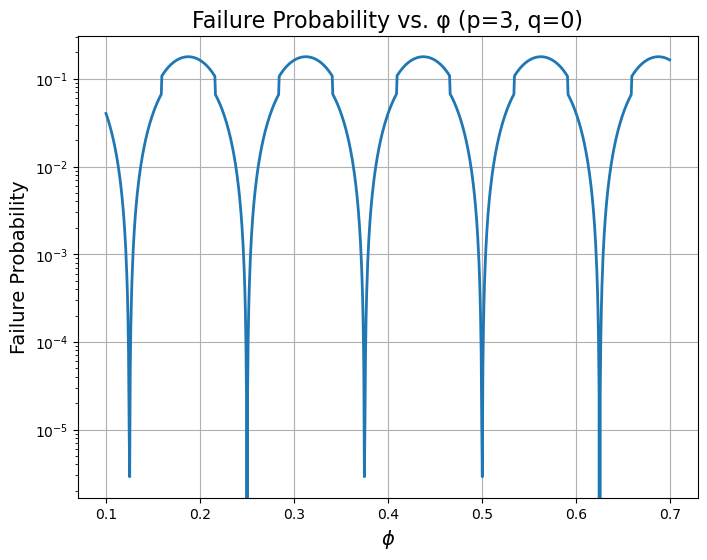

In [30]:
# グラフのプロット
plt.figure(figsize=(8,6))
plt.plot(phi_values, failure_probs, lw=2)
plt.yscale('log')
plt.xlabel(r"$\phi$", fontsize=14)
plt.ylabel("Failure Probability", fontsize=14)
plt.title(f"Failure Probability vs. φ (p={p}, q={q})", fontsize=16)
plt.grid(True)
plt.show()

In [275]:
np.max(failure_probs)

0.1789330509659942

In [277]:
# %% [code]
import numpy as np
import matplotlib.pyplot as plt

def P_k_given_phi_sine(k, phi, p, tol=1e-12):
    r"""
    与えられた φ, p, k に対して、以下の状態
    \[
    |\psi\rangle = \frac{1}{\sqrt{2^p}}\sum_{x=0}^{2^p-1}
         \Biggl[
         \frac{\sqrt{2}}{\sqrt{2^p+1}}
         \sin\!\Bigl(\frac{\pi(x+1)}{2^p+1}\Bigr)
         \,e^{2\pi i\left(\phi-\frac{k}{2^p}\right)x}
         \Biggr]
         \, \ket{k}
    \]
    の \(k\) 成分の振幅
    \[
    A(k) = \frac{1}{\sqrt{2^p}} \sum_{x=0}^{2^p-1} a_{x,\mathrm{sine}}\, e^{2\pi i\left(\phi-\frac{k}{2^p}\right)x}
    \]
    （ただし
    \(
      a_{x,\mathrm{sine}} = \frac{\sqrt{2}}{\sqrt{2^p+1}}
      \sin\!\Bigl(\frac{\pi(x+1)}{2^p+1}\Bigr)
    \)
    ）を計算し、その絶対値の二乗
    \(
      P(k|\phi)=|A(k)|^2
    \)
    を返します.
    """
    a = 2**p
    xs = np.arange(a) 
    # a_x の計算：x=0,...,2^p-1 に対して
    a_x = (np.sqrt(2) / np.sqrt(a+1)) * np.sin(np.pi*(xs+1) / (a+1) )
    # 各 x における位相因子をかけて和をとる
    amplitude = (1/np.sqrt(a)) * np.sum(a_x * np.exp(2 * np.pi * 1j * (phi - k/a) * xs))
    return np.abs(amplitude)**2

def success_probability_for_phi_sine(phi, p, q, tol=1e-12):
    r"""
    固定された φ, p, q に対して、全ての k=0,...,2^p-1 のうち、
    条件
    \[
       2\pi \Bigl|\frac{k}{2^p} - \phi\Bigr|\le \frac{1}{2^q}
    \]
    を満たす k に対応する測定確率の総和（成功確率）を返します。
    """
    a = 2**p
    ks = np.arange(a)
    # 各 k に対する確率を計算
    probs = np.array([P_k_given_phi_sine(k, phi, p, tol) for k in ks])
    # 測定結果 k が条件を満たすかどうかのブール配列
    condition = 2 * np.pi * np.abs(ks / a - phi) <= 1 / (2**q)
    success_prob = np.sum(probs[condition])
    return success_prob

# 固定するパラメータ p, q の設定
q = 0
p = q+3

phi_values = np.linspace(0.1, 0.7, 10000, endpoint=False)

# 各 φ に対する失敗確率 (1 - 成功確率) を計算
failure_probs_sine = []
for phi in phi_values:
    sp = success_probability_for_phi_sine(phi, p, q)
    failure_probs_sine.append(1 - sp)
failure_probs_sine = np.array(failure_probs_sine)


In [284]:
a = 2**p
xs = np.arange(a) 
# a_x の計算：x=0,...,2^p-1 に対して
a_x = (np.sqrt(2) / np.sqrt(a+1)) * np.sin(np.pi*(xs+1) / (a+1) )
# 各 x における位相因子をかけて和をとる

print(a_x)



[0.16122984 0.30301299 0.40824829 0.46424283 0.46424283 0.40824829
 0.30301299 0.16122984]


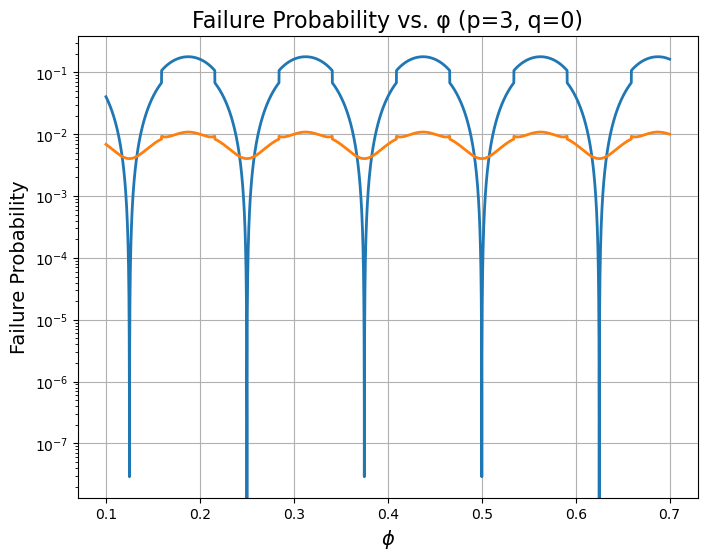

0.1789330509659942
0.01083458203455745


In [278]:
# グラフのプロット
plt.figure(figsize=(8,6))
plt.plot(phi_values, failure_probs, lw=2)
plt.plot(phi_values, failure_probs_sine, lw=2)
plt.yscale('log')
plt.xlabel(r"$\phi$", fontsize=14)
plt.ylabel("Failure Probability", fontsize=14)
plt.title(f"Failure Probability vs. φ (p={p}, q={q})", fontsize=16)
plt.grid(True)
plt.show()

print(max(failure_probs))
print(max(failure_probs_sine))

In [264]:
a = 2**p
xs = np.arange(a)
# a_x の計算：x=0,...,2^p-1 に対して
a_x = (np.sqrt(2) / np.sqrt(a+1)) * np.sin(np.pi*(xs+1) / (a+1) )
print(np.sum(a_x**2))
                                        

1.0000000000000002


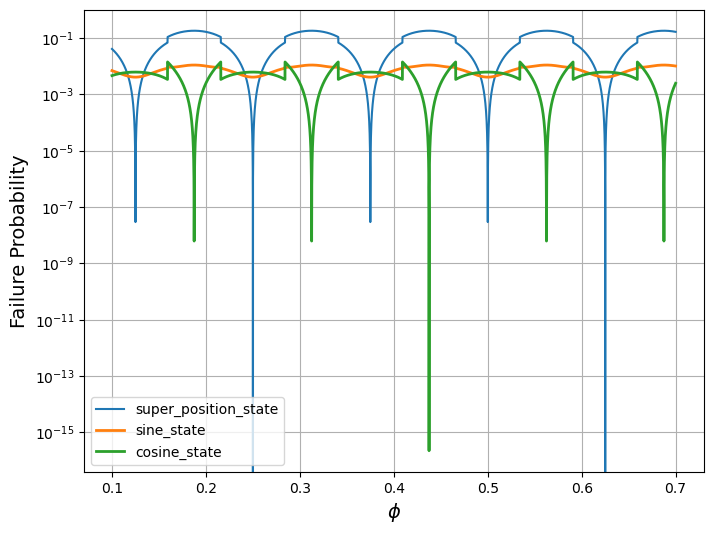

In [282]:
# %% [code]
import numpy as np
import matplotlib.pyplot as plt

def P_k_given_phi_cosine(k, phi, m, tol=1e-12):
    r"""
    与えられた φ, m, k に対して、状態
    \[
      |\psi\rangle = \sum_{x=-2^{m-1}}^{2^{m-1}} 
         \frac{\sqrt{2}\,\cos\!\Bigl(\frac{\pi x}{2^m}\Bigr)}{\sqrt{2^m}}
         \; |x\rangle
    \]
    において、  
    さらに「フーリエ変換的な」操作
    \[
      A(k) = \frac{1}{\sqrt{2^m}} \sum_{x=-2^{m-1}}^{2^{m-1}} 
         \frac{\sqrt{2}\,\cos\!\Bigl(\frac{\pi x}{2^m}\Bigr)}{\sqrt{2^m}}
         \, e^{2\pi i\Bigl(\phi-\frac{k}{2^m}\Bigr)x}
    \]
    を施したときの、測定結果 \(k\) の振幅の絶対値の二乗 \(P(k|\phi)=|A(k)|^2\) を返します.
    """
    # x の範囲： x = -2^(m-1), ..., 2^(m-1)
    xs = np.arange(-2**(m-1), 2**(m-1) )
    # a_x (cosine状態の係数) の計算
    a_x = (np.sqrt(2)/np.sqrt(2**m)) * np.cos(np.pi * xs / (2**m))
    # 変換後の振幅 A(k)
    amplitude = (1/np.sqrt(2**m)) * np.sum(a_x * np.exp(2 * np.pi * 1j * (phi - k/(2**m)) * xs))
    return np.abs(amplitude)**2

def P_k_given_phi_sym_cosine(k, phi, m, tol=1e-12):
    r"""
    与えられた φ, m, k に対して、状態
    \[
      |\psi\rangle = \sum_{x=-2^{m-1}}^{2^{m-1}} 
         \frac{\sqrt{2}\,\cos\!\Bigl(\frac{\pi x}{2^m}\Bigr)}{\sqrt{2^m}}
         \; |x\rangle
    \]
    において、  
    さらに「フーリエ変換的な」操作
    \[
      A(k) = \frac{1}{\sqrt{2^m}} \sum_{x=-2^{m-1}}^{2^{m-1}} 
         \frac{\sqrt{2}\,\cos\!\Bigl(\frac{\pi x}{2^m}\Bigr)}{\sqrt{2^m}}
         \, e^{2\pi i\Bigl(\phi-\frac{k}{2^m}\Bigr)x}
    \]
    を施したときの、測定結果 \(k\) の振幅の絶対値の二乗 \(P(k|\phi)=|A(k)|^2\) を返します.
    """
    # x の範囲： x = -2^(m-1), ..., 2^(m-1)
    xs = np.arange(-2**(m-1), 2**(m-1) )
    # a_x (cosine状態の係数) の計算
    a_x = (np.sqrt(2)/np.sqrt(2**m)) * np.cos(np.pi * (xs + 1/2 ) / (2**m))
    # 変換後の振幅 A(k)
    amplitude = (1/np.sqrt(2**m)) * np.sum(a_x * np.exp(2 * np.pi * 1j * (phi - k/(2**m)) * xs))
    return np.abs(amplitude)**2

def success_probability_for_phi_cosine(phi, m, q, tol=1e-12):
    r"""
    固定された φ, m, q に対して、測定基底（k=0,...,2^m-1）のうち
    \[
      2\pi\Bigl|\frac{k}{2^m}-\phi\Bigr|\le \frac{1}{2^q}
    \]
    を満たす k に対応する測定確率の和を成功確率とします。
    """
    N = 2**m  # k の個数
    ks = np.arange(N)
    # 各 k に対する確率を計算
    probs = np.array([P_k_given_phi_cosine(k, phi, m, tol) for k in ks])
    # 条件を満たす k の選択
    condition = 2*np.pi * np.abs(ks / N - phi) < 1 / (2**q)
    success_prob = np.sum(probs[condition])
    return success_prob


def success_probability_for_phi_sym_cosine(phi, m, q, tol=1e-12):
    r"""
    固定された φ, m, q に対して、測定基底（k=0,...,2^m-1）のうち
    \[
      2\pi\Bigl|\frac{k}{2^m}-\phi\Bigr|\le \frac{1}{2^q}
    \]
    を満たす k に対応する測定確率の和を成功確率とします。
    """
    N = 2**m  # k の個数
    ks = np.arange(N)
    # 各 k に対する確率を計算
    probs = np.array([P_k_given_phi_sym_cosine(k, phi, m, tol) for k in ks])
    # 条件を満たす k の選択
    condition = 2*np.pi * np.abs(ks / N - phi) < 1 / (2**q)
    success_prob = np.sum(probs[condition])
    return success_prob

# ----- パラメータの設定 -----
     # コサイン状態のパラメータ（x の範囲は -2^(m-1)～2^(m-1)）
q = 0
m = q+3      # 条件のパラメータ
# φ のグリッド： [0,1) を 10000 分割
phi_values = np.linspace(0.1, 0.7, 10000, endpoint=False)

# 各 φ に対して、成功確率＝条件を満たす k の確率の総和を計算し、その補数（失敗確率）を求める
failure_probs_cos = []
failure_probs_sym_cos = []
for phi in phi_values:
    sp = success_probability_for_phi_cosine(phi, m, q)
    failure_probs_cos.append(1 - sp)
failure_probs_cos = np.array(failure_probs_cos)

for phi in phi_values:
    sp = success_probability_for_phi_sym_cosine(phi, m, q)
    failure_probs_sym_cos.append(1 - sp)
failure_probs_sym_cos = np.array(failure_probs_sym_cos)

# グラフのプロット
plt.figure(figsize=(8,6))
plt.plot(phi_values, failure_probs, label= 'super_position_state')
plt.plot(phi_values, failure_probs_sine, lw=2, label= 'sine_state')
# plt.plot(phi_values, failure_probs_cos, lw=2, label= 'cosine_state')
plt.plot(phi_values, failure_probs_sym_cos, lw=2, label= 'cosine_state')
plt.yscale('log')
plt.xlabel(r"$\phi$", fontsize=14)
plt.ylabel("Failure Probability", fontsize=14)
# plt.title(f"Failure Probability vs. φ (m={m}, q={q}) with cosine state", fontsize=16)
plt.grid(True)
plt.legend()

plt.savefig('444.pdf')



In [280]:
np.max(failure_probs_cos)

0.02074393732020341

In [255]:
m = 3
a = 2**p
xs = np.arange(-2**(m-1), 2**(m-1) )
    # a_x (cosine状態の係数) の計算
a_x = (np.sqrt(2)/np.sqrt(2**m)) * np.cos(np.pi * (xs+1/2)  / (2**m))
print(np.sum(a_x**2) )


1.0


In [234]:
(np.log(1)- meanax*M)/(root_var*(M))

0.3818577164538798

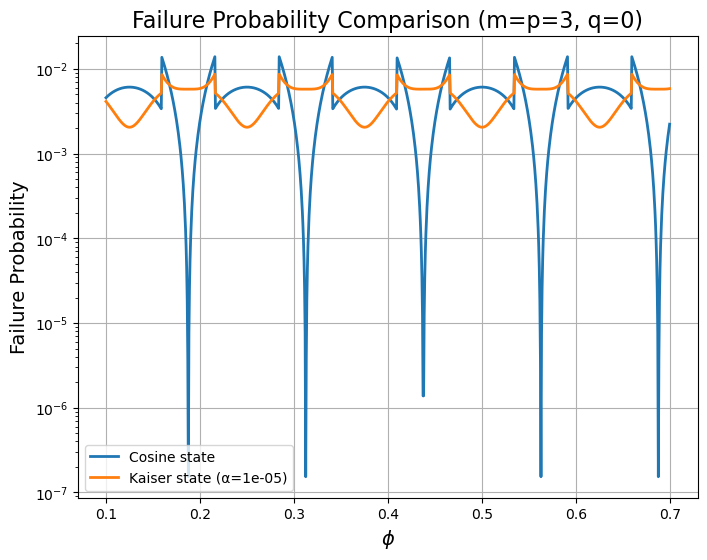

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import i0   # 修正Bessel関数 I₀ を利用

# ----- 元の cosine 状態の場合の関数定義 -----
def P_k_given_phi_cosine(k, phi, m, tol=1e-12):
    r"""
    与えられた φ, m, k に対して，状態
    \[
      |\psi\rangle = \sum_{x=-2^{m-1}}^{2^{m-1}-1} 
         \frac{\sqrt{2}\,\cos\!\Bigl(\frac{\pi (x+1/2)}{2^m}\Bigr)}{\sqrt{2^m}}
         \; |x\rangle
    \]
    に対し，フーリエ変換的な操作
    \[
      A(k) = \frac{1}{\sqrt{2^m}} \sum_{x=-2^{m-1}}^{2^{m-1}-1} 
         \frac{\sqrt{2}\,\cos\!\Bigl(\frac{\pi (x+1/2)}{2^m}\Bigr)}{\sqrt{2^m}}
         \, e^{2\pi i\Bigl(\phi-\frac{k}{2^m}\Bigr)x}
    \]
    を施したときの測定結果 \(k\) の確率 \(P(k|\phi)=|A(k)|^2\) を返します.
    """
    xs = np.arange(-2**(m-1), 2**(m-1))
    a_x = (np.sqrt(2)/np.sqrt(2**m)) * np.cos(np.pi * (xs + 0.5) / (2**m))
    amplitude = (1/np.sqrt(2**m)) * np.sum(a_x * np.exp(2 * np.pi * 1j * (phi - k/(2**m)) * xs))
    return np.abs(amplitude)**2

def success_probability_for_phi_cosine(phi, m, q, tol=1e-12):
    r"""
    固定された φ, m, q に対して，測定基底（k=0,...,2^m-1）のうち
    \[
      2\pi\Bigl|\frac{k}{2^m}-\phi\Bigr|\le \frac{1}{2^q}
    \]
    を満たす k に対応する測定確率の和を成功確率として返します.
    """
    N = 2**m
    ks = np.arange(N)
    probs = np.array([P_k_given_phi_cosine(k, phi, m, tol) for k in ks])
    condition = 2*np.pi * np.abs(ks / N - phi) < 1 / (2**q)
    return np.sum(probs[condition])


# ----- Kaiser 状態の場合の関数定義 -----
def P_k_given_phi_Kaiser(k, phi, p, alpha, tol=1e-12):
    r"""
    与えられた φ, p, α, k に対して，状態
    \[
      |\psi\rangle = \sum_{x=-2^{p-1}}^{2^{p-1}-1} 
      c_{x}^{(\mathrm{Kaiser})}\;|x\rangle,
    \]
    ただし
    \[
      c_{x}^{(\mathrm{Kaiser})} = \frac{1}{2^p}\frac{I_0\Bigl(\pi\alpha\sqrt{1-(x/2^p)^2}\Bigr)}{I_0(\pi\alpha)},
    \]
    において，フーリエ変換的な操作
    \[
      A(k) = \frac{1}{\sqrt{2^p}} \sum_{x=-2^{p-1}}^{2^{p-1}-1} 
         c_{x}^{(\mathrm{Kaiser})}\, e^{2\pi i\Bigl(\phi-\frac{k}{2^p}\Bigr)x}
    \]
    を施したときの測定結果 \(k\) の確率 \(P(k|\phi)=|A(k)|^2\) を返します.
    """
    xs = np.arange(-2**(p-1), 2**(p-1))
    xs = 2*xs+1
    alpha = 1
    a_x = ( i0(np.pi * alpha * np.sqrt(1 - (xs/2**(p) )**2) ) / i0(np.pi * alpha) )
    a_x = a_x / np.sqrt(np.sum(a_x**2))
    xs = (xs-1)/2
    amplitude = (1/np.sqrt(2**p)) * np.sum(a_x * np.exp(2 * np.pi * 1j * (phi - k/(2**p)) * xs))
    return np.abs(amplitude)**2

def success_probability_for_phi_Kaiser(phi, p, alpha, q, tol=1e-12):
    r"""
    固定された φ, p, α, q に対して，測定基底（k=0,...,2^p-1）のうち
    \[
      2\pi\Bigl|\frac{k}{2^p}-\phi\Bigr|\le \frac{1}{2^q}
    \]
    を満たす k に対応する測定確率の和を成功確率として返します.
    """
    N = 2**p
    ks = np.arange(N)
    probs = np.array([P_k_given_phi_Kaiser(k, phi, p, alpha, tol) for k in ks])
    condition = 2*np.pi * np.abs(ks / N - phi) < 1 / (2**q)
    return np.sum(probs[condition])


# ----- パラメータ設定 -----
q = 0
m = q + 3     # cosine 状態でのパラメータ m
p = m         # Kaiser 状態では p を用いる（同じサイズとする）
alpha = 1e-5   # Kaiser 状態のパラメータ（例として1.5を使用）
phi_values = np.linspace(0.1, 0.7, 1000, endpoint=False)

# 各 φ に対して失敗確率（成功確率の補数）を計算
failure_probs_cosine = []
failure_probs_Kaiser = []
for phi in phi_values:
    sp_cos = success_probability_for_phi_cosine(phi, m, q)
    failure_probs_cosine.append(1 - sp_cos)
    
    sp_Kaiser = success_probability_for_phi_Kaiser(phi, p, alpha, q)
    failure_probs_Kaiser.append(1 - sp_Kaiser)
    
failure_probs_cosine = np.array(failure_probs_cosine)
failure_probs_Kaiser = np.array(failure_probs_Kaiser)

# グラフのプロット（両状態を比較）
plt.figure(figsize=(8,6))
plt.plot(phi_values, failure_probs_cosine, lw=2, label='Cosine state')
plt.plot(phi_values, failure_probs_Kaiser, lw=2, label='Kaiser state (α={})'.format(alpha))
plt.yscale('log')
plt.xlabel(r"$\phi$", fontsize=14)
plt.ylabel("Failure Probability", fontsize=14)
plt.title(f"Failure Probability Comparison (m=p={m}, q={q})", fontsize=16)
plt.grid(True)
plt.legend()
plt.savefig('Comparison_Cosine_vs_Kaiser.pdf')
plt.show()


In [27]:
p=3
xs = np.arange(-2**(p-1), 2**(p-1))
xs = 2*xs+1
alpha = 1e-5
a_x = ( i0(np.pi * alpha * np.sqrt(1 - (xs/2**(p) )**2) ) / i0(np.pi * alpha) )
a_x = a_x / np.sqrt(np.sum(a_x**2))
# amplitude = (1/np.sqrt(2**p)) * np.sum(a_x * np.exp(2 * np.pi * 1j * (phi - k/(2**p)) * xs))
print(np.sum(a_x**2))
print(a_x)


0.9999999999999999
[0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
 0.35355339 0.35355339]


[-7 -5 -3 -1  1  3  5  7]


Font 'default' does not have a glyph for '\u5404' [U+5404], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u72b6' [U+72b6], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u614b' [U+614b], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u306e' [U+306e], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u4fc2' [U+4fc2], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u6570' [U+6570], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5404' [U+5404], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u72b6' [U+72b6], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u614b' [U+614b], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u306e' [U+306e], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u4fc2' [U+4fc2], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u6570' [U+6570], substituting with a dummy symbol.


パラメータ p = 3
α = 1
ν の取りうる値: [-7 -5 -3 -1  1  3  5  7]


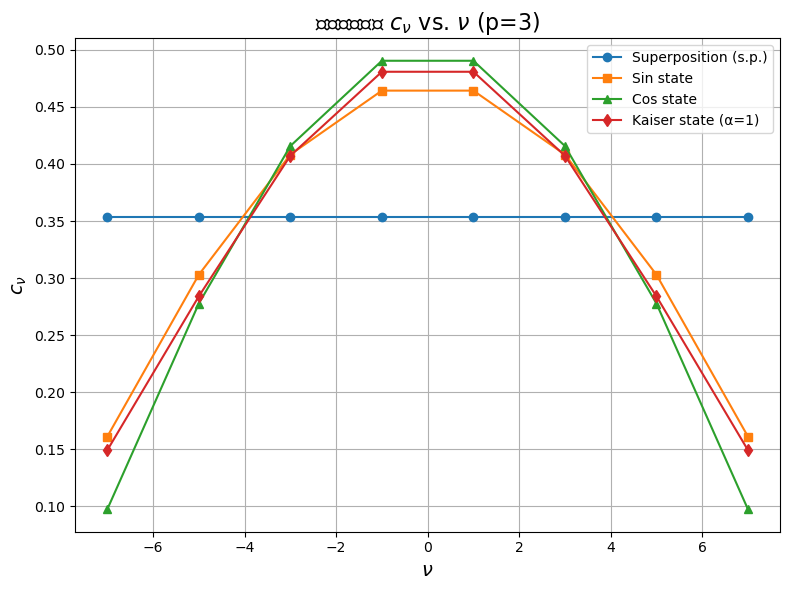

In [51]:
import numpy as np
from scipy.special import i0

# ----- パラメータの設定 -----
p = 3  # 例として p = 3 とする．
alpha = 1  # Kaiser状態のパラメータ

# ν の取りうる値の集合:
# ν ∈ { -(2^p-1), -(2^p-3), ..., 2^p-3, 2^p-1 }
nus = np.arange(-(2**p - 1), 2**p, 2)
# 例：p = 3 の場合， nus = [-7, -5, -3, -1, 1, 3, 5, 7]

# ----- 各状態の係数の定義 -----

# (1) Superposition state (s.p.)
def c_nu_sp(nu, p):
    return 1/np.sqrt(2**p)

# (2) Sin state
def c_nu_sin(nu, p):
    # ここでは問題文に記載された式そのまま：
    # c_nu^(sin) = (sqrt(2)/sqrt(2^p+1)) * sin( ((nu+9)*pi) / (2*(2^p+1)) )
    return (np.sqrt(2) / np.sqrt(2**p + 1)) * np.sin(((nu + 9) * np.pi) / (2 * (2**p + 1)))

# (3) Cos state
def c_nu_cos(nu, p):
    return (np.sqrt(2) / np.sqrt(2**p)) * np.cos((np.pi * nu) / (2**(p+1)))

# (4) Kaiser state
def c_nu_kaiser(nu, p, alpha):
    ax = ( i0(np.pi * alpha * np.sqrt(1 - (nu/(2**p))**2)) / i0(np.pi * alpha) )
    return ax

# ----- 各状態の係数の計算 -----
c_sp = np.array([ c_nu_sp(nu, p) for nu in nus ])
c_sin = np.array([ c_nu_sin(nu, p) for nu in nus ])
c_cos = np.array([ c_nu_cos(nu, p) for nu in nus ])
c_kaiser = np.array([ c_nu_kaiser(nu, p, alpha) for nu in nus ])


# ----- 結果の表示 -----
print("パラメータ p =", p)
print("α =", alpha)
print("ν の取りうる値:", nus)
c_sp = np.array([ c_nu_sp(nu, p) for nu in nus ])
c_sin = np.array([ c_nu_sin(nu, p) for nu in nus ])
c_cos = np.array([ c_nu_cos(nu, p) for nu in nus ])
# c_kaiser = np.array([ c_nu_kaiser(nu, p, alpha) for nu in nus ])
c_kaiser = 1/ np.sqrt(np.sum(c_kaiser**2)) * c_kaiser

# ----- グラフのプロット -----
plt.figure(figsize=(8,6))
plt.plot(nus, c_sp, 'o-', label="Superposition (s.p.)")
plt.plot(nus, c_sin, 's-', label="Sin state")
plt.plot(nus, c_cos, '^-', label="Cos state")
plt.plot(nus, c_kaiser, 'd-', label="Kaiser state (α={})".format(alpha))

plt.xlabel(r"$\nu$", fontsize=14)
plt.ylabel(r"$c_\nu$", fontsize=14)
plt.title("各状態の係数 $c_\\nu$ vs. $\\nu$ (p={})".format(p), fontsize=16)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [45]:
c_kaiser 

array([0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125])

In [38]:
ax = 1/ np.sqrt(np.sum(c_kaiser**2)) * c_kaiser
np.sum(ax**2)

1.0000000000000002

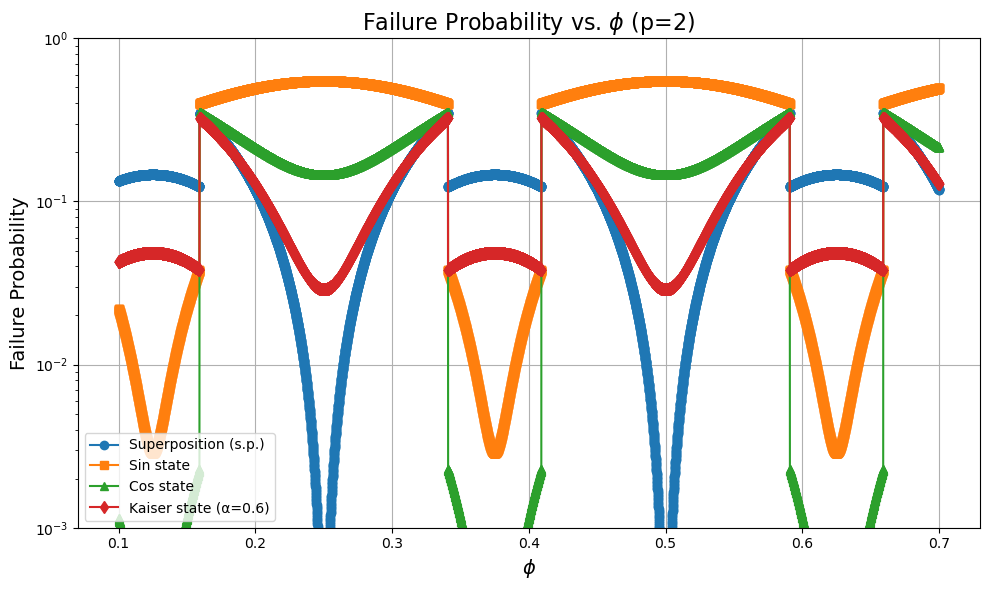

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import i0

# ----- パラメータの設定 -----
p = 2           # 例として p = 3
alpha = 0.6         # Kaiser状態のパラメータ
N = 2**p            # 測定基底のサイズ

# ν の取りうる値の集合: ν ∈ { -(2^p-1), -(2^p-3), ..., 2^p-3, 2^p-1 }
nus = np.arange(-(2**p - 1), 2**p, 2)
# 例: p=3 の場合, nus = [-7, -5, -3, -1, 1, 3, 5, 7]

# ----- 各状態の係数の定義 -----

# (1) Superposition state (s.p.)
def c_nu_sp(nu, p):
    return 1/np.sqrt(2**p)

# (2) Sin state
def c_nu_sin(nu, p):
    # 定義に従う (ここでは問題文の式をそのまま使用)
    return (np.sqrt(2) / np.sqrt(2**p + 1)) * np.sin(((nu + 9) * np.pi) / (2 * (2**p + 1)))

# (3) Cos state
def c_nu_cos(nu, p):
    return (np.sqrt(2) / np.sqrt(2**p)) * np.cos((np.pi * nu) / (2**(p+1)))

# (4) Kaiser state
def c_nu_kaiser(nu, p, alpha):
    return (1 / (2**p)) * ( i0(np.pi * alpha * np.sqrt(1 - (nu/(2**p))**2)) / i0(np.pi * alpha) )

# ----- 各状態の c_nu の計算 -----
c_sp     = np.array([ c_nu_sp(nu, p) for nu in nus ])
c_sin    = np.array([ c_nu_sin(nu, p) for nu in nus ])
c_cos    = np.array([ c_nu_cos(nu, p) for nu in nus ])
c_kaiser = np.array([ c_nu_kaiser(nu, p, alpha) for nu in nus ])
c_kaiser = 1/ np.sqrt(np.sum(c_kaiser**2)) * c_kaiser

# ----- 振幅 A(k) の計算関数 -----
def A_k(k, phi, p, nus, c_nus):
    """
    与えられた状態の係数 c_nus を用いて，
    A(k)= (1/sqrt(2^p)) * Σ_{ν∈N} c_nus * exp[2π i (φ - k/2^p) ν]
    を計算する．
    """
    phase_factors = np.exp(2 * np.pi * 1j * (phi - k/2**p) * (nus + 7)/2 )
    return 1/np.sqrt(2**p) * np.sum(c_nus * phase_factors)

# ----- 各状態に対して P(k|phi) の計算と失敗確率の求め方 -----
def compute_failure_probability(c_nus, p, phi):
    """
    与えられた c_nus（状態の係数配列）に対して，
    各 k に対する振幅 A(k) および確率 P(k|phi)=|A(k)|^2 を計算し，
    条件 |k/2^p - φ| > 1/(2π) を満たす k の P(k|phi) の和を失敗確率として返す．
    """
    N = 2**p
    P = np.zeros(N)
    for k in range(N):
        amplitude = A_k(k, phi, p, nus, c_nus)
        P[k] = np.abs(amplitude)**2
    # 条件を満たす k のインデックスの集合 A
    A_indices = [k for k in range(N) if abs(k/2**p - phi) > 1/(2*np.pi)]
    failure_probability = np.sum(P[A_indices])
    return failure_probability

# ----- φ を変化させたときの失敗確率の計算 -----
phi_values = np.linspace(0.1, 0.7, 10000, endpoint=False)
failure_sp_values     = np.array([ compute_failure_probability(c_sp, p, phi) for phi in phi_values ])
failure_sin_values    = np.array([ compute_failure_probability(c_sin, p, phi) for phi in phi_values ])
failure_cos_values    = np.array([ compute_failure_probability(c_cos, p, phi) for phi in phi_values ])
failure_kaiser_values = np.array([ compute_failure_probability(c_kaiser, p, phi) for phi in phi_values ])

# ----- 結果のプロット -----
plt.figure(figsize=(10,6))
plt.plot(phi_values, failure_sp_values, 'o-', label="Superposition (s.p.)")
plt.plot(phi_values, failure_sin_values, 's-', label="Sin state")
plt.plot(phi_values, failure_cos_values, '^-', label="Cos state")
plt.plot(phi_values, failure_kaiser_values, 'd-', label="Kaiser state (α={})".format(alpha))
plt.yscale('log')
plt.xlabel(r"$\phi$", fontsize=14)
plt.ylabel("Failure Probability", fontsize=14)
plt.ylim([10**-3, 1])
plt.title(r"Failure Probability vs. $\phi$ (p={})".format(p), fontsize=16)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


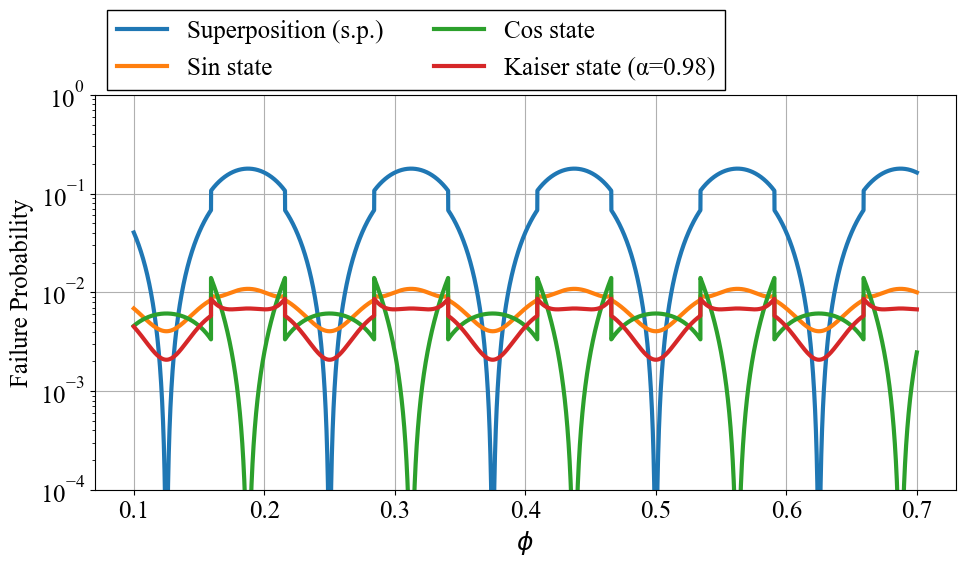

In [89]:
# ----- 結果のプロット -----
plt.figure(figsize=(10,6))
plt.rcParams['font.family'] = 'Times New Roman' 
plt.rcParams["font.size"] = 18
plt.rcParams["legend.fancybox"] = False # 丸角
plt.rcParams["legend.framealpha"] = 1 # 透明度の指定、0で塗りつぶしなし
plt.rcParams["legend.edgecolor"] = 'black' # edgeの色を変更
plt.plot(phi_values, failure_sp_values,  linewidth = 3, label="Superposition (s.p.)")
plt.plot(phi_values, failure_sin_values,  linewidth = 3, label="Sin state")
plt.plot(phi_values, failure_cos_values,  linewidth = 3,label="Cos state")
plt.plot(phi_values, failure_kaiser_values,  linewidth = 3, label="Kaiser state (α={})".format(alpha))
plt.yscale('log')
plt.xlabel(r"$\phi$", fontsize=18)
plt.ylabel("Failure Probability", fontsize=18)
plt.ylim([10**-4, 1])
# plt.title(r"Failure Probability vs. $\phi$ (p={})".format(p), fontsize=18)
plt.grid(True)
plt.legend(ncol=2, bbox_to_anchor=(0., 0.98, 1., 0.98), loc=3)
plt.tight_layout()

plt.savefig("Probe.pdf")

In [2]:
print(np.max(failure_sp_values))
print(np.max(failure_sin_values))
print(np.max(failure_cos_values))
print(np.max(failure_kaiser_values))

0.3480189935274233
0.5477457514062631
0.3532686438196987
0.3250457836042733


最小の最大失敗確率: 0.3244405210020209
最適な alpha: 0.6012024048096193


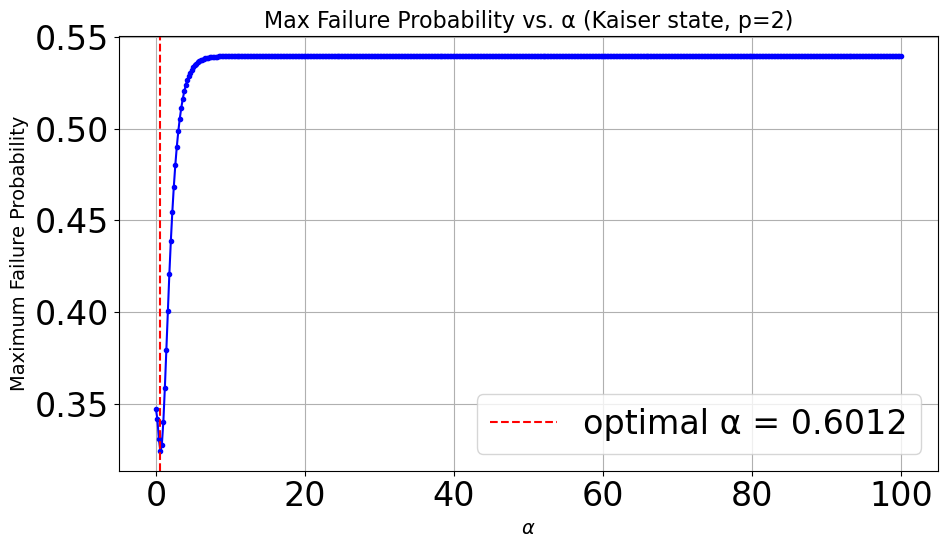

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import i0

# ----- パラメータの設定 -----
p = 2         # 例として p = 3
N = 2**p            # 測定基底のサイズ
phi_values = np.linspace(0.3, 0.7, 1090, endpoint=False)

# ν の取りうる値の集合: ν ∈ { -(2^p-1), -(2^p-3), ..., 2^p-3, 2^p-1 }
nus = np.arange(-(2**p - 1), 2**p, 2)
# 例: p=3 の場合, nus = [-7, -5, -3, -1, 1, 3, 5, 7]

# ----- Kaiser状態の係数の定義 -----
def c_nu_kaiser(nu, p, alpha):
    """Kaiser状態の係数（正規化前）"""
    return (1 / (2**p)) * ( i0(np.pi * alpha * np.sqrt(1 - (nu/(2**p))**2)) / i0(np.pi * alpha) )

# ----- 振幅 A(k) の計算関数 -----
def A_k(k, phi, p, nus, c_nus):
    """
    与えられた状態の係数 c_nus を用いて，
    A(k)= (1/sqrt(2^p)) * Σ_{ν∈N} c_nus * exp[2π i (φ - k/2^p) ν']
    を計算する．
    ここでは ν' = (nus + 7)/2 として、インデックスを 0,...,7 に写像している．
    """
    # ※ nus の範囲 [-7, -5, ..., 7] を 0,...,7 に写像するため (nus+7)/2 とする
    phase_factors = np.exp(2 * np.pi * 1j * (phi - k/2**p) * ((nus + 7)/2))
    return 1/np.sqrt(2**p) * np.sum(c_nus * phase_factors)

# ----- 各状態に対して P(k|phi) の計算と失敗確率の求め方 -----
def compute_failure_probability(c_nus, p, phi):
    """
    与えられた c_nus（状態の係数配列）に対して，
    各 k に対する振幅 A(k) および確率 P(k|phi)=|A(k)|^2 を計算し，
    条件 |k/2^p - φ| > 1/(2π) を満たす k の P(k|phi) の和を失敗確率として返す．
    """
    N = 2**p
    P = np.zeros(N)
    for k in range(N):
        amplitude = A_k(k, phi, p, nus, c_nus)
        P[k] = np.abs(amplitude)**2
    # 測定結果 k のうち、 |k/2^p - φ| > 1/(2π) を満たす k を集める
    A_indices = [k for k in range(N) if abs(k/2**p - phi) > 1/(2*np.pi)]
    failure_probability = np.sum(P[A_indices])
    return failure_probability

# ----- α を変化させたときの Kaiser 状態の失敗確率の最大値を探索 -----
alpha_candidates = np.linspace(0, 100, 500)  # 例：500分割
max_failure_list = []  # 各 α に対する φ での最大の失敗確率

for alpha in alpha_candidates:
    # Kaiser状態の係数を計算し、正規化する
    c_kaiser = np.array([ c_nu_kaiser(nu, p, alpha) for nu in nus ])
    norm = np.sqrt(np.sum(c_kaiser**2))
    c_kaiser = c_kaiser / norm
    # φ ごとに失敗確率を計算し、その最大値を記録
    failure_values = np.array([ compute_failure_probability(c_kaiser, p, phi) for phi in phi_values ])
    max_failure = np.max(failure_values)
    max_failure_list.append(max_failure)

max_failure_list = np.array(max_failure_list)

# 最小の最大失敗確率となる α を探索
min_index = np.argmin(max_failure_list)
optimal_alpha = alpha_candidates[min_index]
optimal_failure = max_failure_list[min_index]

print("最小の最大失敗確率:", optimal_failure)
print("最適な alpha:", optimal_alpha)

# ----- 結果のプロット: α に対する最大失敗確率 -----
plt.figure(figsize=(10,6))
plt.plot(alpha_candidates, max_failure_list, 'b.-')
plt.xlabel(r"$\alpha$", fontsize=14)
plt.ylabel("Maximum Failure Probability", fontsize=14)
plt.title("Max Failure Probability vs. α (Kaiser state, p={})".format(p), fontsize=16)
plt.grid(True)
plt.axvline(optimal_alpha, color='r', linestyle='--', label=f"optimal α = {optimal_alpha:.4f}")
plt.legend()
plt.tight_layout()
plt.show()


最小の最大失敗確率: 0.008588899495569357
最適な alpha: 0.977956132264529


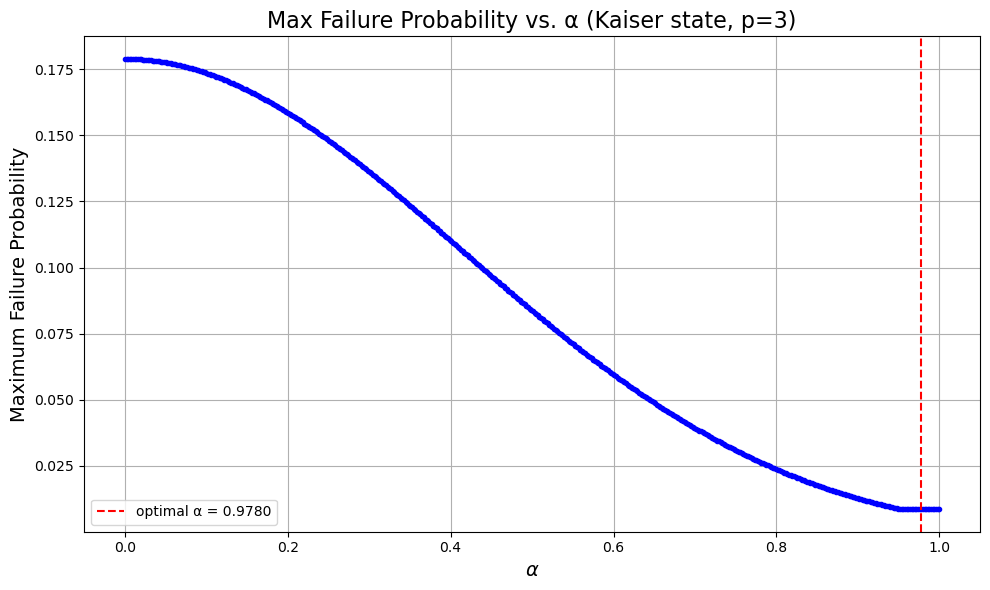

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import i0

# ----- パラメータの設定 -----
p = 3               # 例として p = 3
N = 2**p            # 測定基底のサイズ
phi_values = np.linspace(0.1, 0.7, 1000, endpoint=False)

# ν の取りうる値の集合: ν ∈ { -(2^p-1), -(2^p-3), ..., 2^p-3, 2^p-1 }
nus = np.arange(-(2**p - 1), 2**p, 2)
# 例: p=3 の場合, nus = [-7, -5, -3, -1, 1, 3, 5, 7]

# ----- Kaiser状態の係数の定義 -----
def c_nu_kaiser(nu, p, alpha):
    """Kaiser状態の係数（正規化前）"""
    return (1 / (2**p)) * ( i0(np.pi * alpha * np.sqrt(1 - (nu/(2**p))**2)) / i0(np.pi * alpha) )

# ----- 振幅 A(k) の計算関数 -----
def A_k(k, phi, p, nus, c_nus):
    """
    与えられた状態の係数 c_nus を用いて，
    A(k)= (1/sqrt(2^p)) * Σ_{ν∈N} c_nus * exp[2π i (φ - k/2^p) ν']
    を計算する．
    ここでは ν' = (nus + 7)/2 として、インデックスを 0,...,7 に写像している．
    """
    # ※ nus の範囲 [-7, -5, ..., 7] を 0,...,7 に写像するため (nus+7)/2 とする
    phase_factors = np.exp(2 * np.pi * 1j * (phi - k/2**p) * ((nus + 7)/2))
    return 1/np.sqrt(2**p) * np.sum(c_nus * phase_factors)

# ----- 各状態に対して P(k|phi) の計算と失敗確率の求め方 -----
def compute_failure_probability(c_nus, p, phi):
    """
    与えられた c_nus（状態の係数配列）に対して，
    各 k に対する振幅 A(k) および確率 P(k|phi)=|A(k)|^2 を計算し，
    条件 |k/2^p - φ| > 1/(2π) を満たす k の P(k|phi) の和を失敗確率として返す．
    """
    N = 2**p
    P = np.zeros(N)
    for k in range(N):
        amplitude = A_k(k, phi, p, nus, c_nus)
        P[k] = np.abs(amplitude)**2
    # 測定結果 k のうち、 |k/2^p - φ| > 1/(2π) を満たす k を集める
    A_indices = [k for k in range(N) if abs(k/2**p - phi) > 1/(2*np.pi)]
    failure_probability = np.sum(P[A_indices])
    return failure_probability

# ----- α を変化させたときの Kaiser 状態の失敗確率の最大値を探索 -----
alpha_candidates = np.linspace(1e-5, 1, 500)  # 例：500分割
max_failure_list = []  # 各 α に対する φ での最大の失敗確率

for alpha in alpha_candidates:
    # Kaiser状態の係数を計算し、正規化する
    c_kaiser = np.array([ c_nu_kaiser(nu, p, alpha) for nu in nus ])
    norm = np.sqrt(np.sum(c_kaiser**2))
    c_kaiser = c_kaiser / norm
    # φ ごとに失敗確率を計算し、その最大値を記録
    failure_values = np.array([ compute_failure_probability(c_kaiser, p, phi) for phi in phi_values ])
    max_failure = np.max(failure_values)
    max_failure_list.append(max_failure)

max_failure_list = np.array(max_failure_list)

# 最小の最大失敗確率となる α を探索
min_index = np.argmin(max_failure_list)
optimal_alpha = alpha_candidates[min_index]
optimal_failure = max_failure_list[min_index]

print("最小の最大失敗確率:", optimal_failure)
print("最適な alpha:", optimal_alpha)

# ----- 結果のプロット: α に対する最大失敗確率 -----
plt.figure(figsize=(10,6))
plt.plot(alpha_candidates, max_failure_list, 'b.-')
plt.xlabel(r"$\alpha$", fontsize=14)
plt.ylabel("Maximum Failure Probability", fontsize=14)
plt.title("Max Failure Probability vs. α (Kaiser state, p={})".format(p), fontsize=16)
plt.grid(True)
plt.axvline(optimal_alpha, color='r', linestyle='--', label=f"optimal α = {optimal_alpha:.4f}")
plt.legend()
plt.tight_layout()
plt.show()

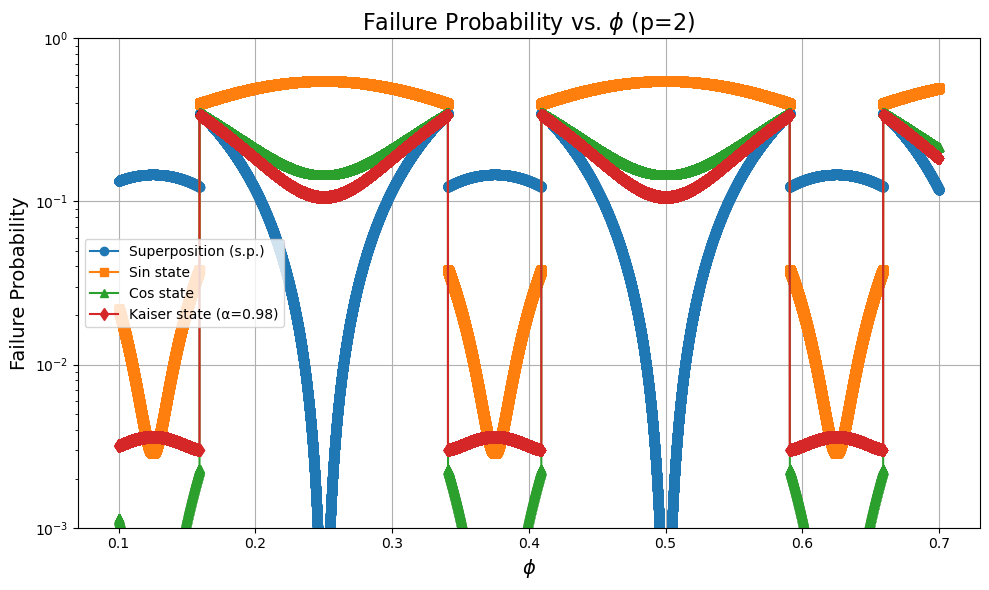

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import i0

# ----- パラメータの設定 -----
p = 2               # 例として p = 3
alpha = 0.98         # Kaiser状態のパラメータ
N = 2**p            # 測定基底のサイズ

# ν の取りうる値の集合: ν ∈ { -(2^p-1), -(2^p-3), ..., 2^p-3, 2^p-1 }
nus = np.arange(-(2**p - 1), 2**p, 2)
# 例: p=3 の場合, nus = [-7, -5, -3, -1, 1, 3, 5, 7]

# ----- 各状態の係数の定義 -----

# (1) Superposition state (s.p.)
def c_nu_sp(nu, p):
    return 1/np.sqrt(2**p)

# (2) Sin state
def c_nu_sin(nu, p):
    # 定義に従う (ここでは問題文の式をそのまま使用)
    return (np.sqrt(2) / np.sqrt(2**p + 1)) * np.sin(((nu + 9) * np.pi) / (2 * (2**p + 1)))

# (3) Cos state
def c_nu_cos(nu, p):
    return (np.sqrt(2) / np.sqrt(2**p)) * np.cos((np.pi * nu) / (2**(p+1)))

# (4) Kaiser state
def c_nu_kaiser(nu, p, alpha):
    return (1 / (2**p)) * ( i0(np.pi * alpha * np.sqrt(1 - (nu/(2**p))**2)) / i0(np.pi * alpha) )

# ----- 各状態の c_nu の計算 -----
c_sp     = np.array([ c_nu_sp(nu, p) for nu in nus ])
c_sin    = np.array([ c_nu_sin(nu, p) for nu in nus ])
c_cos    = np.array([ c_nu_cos(nu, p) for nu in nus ])
c_kaiser = np.array([ c_nu_kaiser(nu, p, alpha) for nu in nus ])
c_kaiser = 1/ np.sqrt(np.sum(c_kaiser**2)) * c_kaiser

# ----- 振幅 A(k) の計算関数 -----
def A_k(k, phi, p, nus, c_nus):
    """
    与えられた状態の係数 c_nus を用いて，
    A(k)= (1/sqrt(2^p)) * Σ_{ν∈N} c_nus * exp[2π i (φ - k/2^p) ν]
    を計算する．
    """
    phase_factors = np.exp(2 * np.pi * 1j * (phi - k/2**p) * (nus + 7)/2 )
    return 1/np.sqrt(2**p) * np.sum(c_nus * phase_factors)

# ----- 各状態に対して P(k|phi) の計算と失敗確率の求め方 -----
def compute_failure_probability(c_nus, p, phi):
    """
    与えられた c_nus（状態の係数配列）に対して，
    各 k に対する振幅 A(k) および確率 P(k|phi)=|A(k)|^2 を計算し，
    条件 |k/2^p - φ| > 1/(2π) を満たす k の P(k|phi) の和を失敗確率として返す．
    """
    N = 2**p
    P = np.zeros(N)
    for k in range(N):
        amplitude = A_k(k, phi, p, nus, c_nus)
        P[k] = np.abs(amplitude)**2
    # 条件を満たす k のインデックスの集合 A
    A_indices = [k for k in range(N) if abs(k/2**p - phi) > 1/(2*np.pi)]
    failure_probability = np.sum(P[A_indices])
    return failure_probability

# ----- φ を変化させたときの失敗確率の計算 -----
phi_values = np.linspace(0.1, 0.7, 100000, endpoint=False)
failure_sp_values     = np.array([ compute_failure_probability(c_sp, p, phi) for phi in phi_values ])
failure_sin_values    = np.array([ compute_failure_probability(c_sin, p, phi) for phi in phi_values ])
failure_cos_values    = np.array([ compute_failure_probability(c_cos, p, phi) for phi in phi_values ])
failure_kaiser_values = np.array([ compute_failure_probability(c_kaiser, p, phi) for phi in phi_values ])

# ----- 結果のプロット -----
plt.figure(figsize=(10,6))
plt.plot(phi_values, failure_sp_values, 'o-', label="Superposition (s.p.)")
plt.plot(phi_values, failure_sin_values, 's-', label="Sin state")
plt.plot(phi_values, failure_cos_values, '^-', label="Cos state")
plt.plot(phi_values, failure_kaiser_values, 'd-', label="Kaiser state (α={})".format(alpha))
plt.yscale('log')
plt.xlabel(r"$\phi$", fontsize=14)
plt.ylabel("Failure Probability", fontsize=14)
plt.ylim([10**-3, 1])
plt.title(r"Failure Probability vs. $\phi$ (p={})".format(p), fontsize=16)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Paper用

/opt/anaconda3/envs/qiskit-related/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


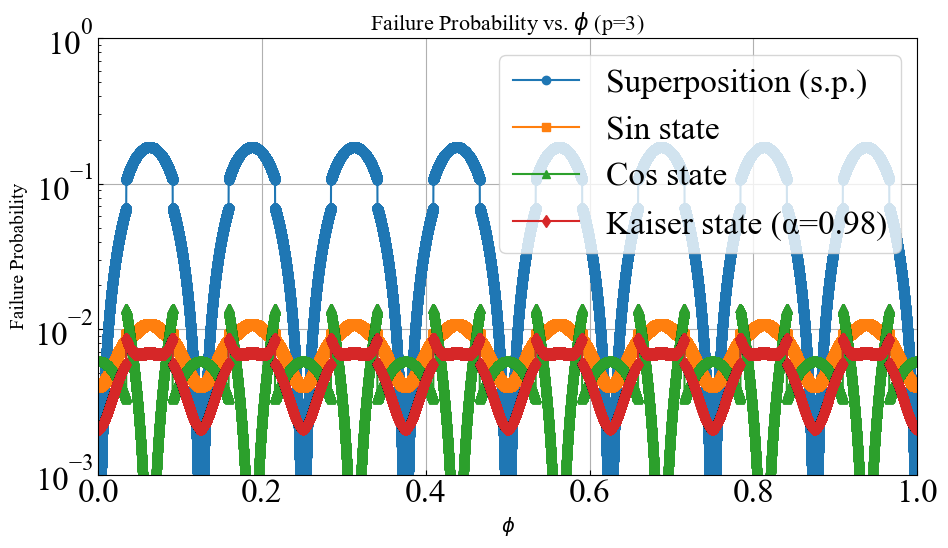

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import i0

# ----- パラメータの設定 -----
p = 3               # 例として p = 3
alpha = 0.98     # Kaiser状態のパラメータ
N = 2**p            # 測定基底のサイズ

# ν の取りうる値の集合: ν ∈ { -(2^p-1), -(2^p-3), ..., 2^p-3, 2^p-1 }
nus = np.arange(-(2**p - 1), 2**p, 2)
# 例: p=3 の場合, nus = [-7, -5, -3, -1, 1, 3, 5, 7]

# ----- 各状態の係数の定義 -----

# (1) Superposition state (s.p.)
def c_nu_sp(nu, p):
    return 1/np.sqrt(2**p)

# (2) Sin state
def c_nu_sin(nu, p):
    # 定義に従う (ここでは問題文の式をそのまま使用)
    # return (np.sqrt(2) / np.sqrt(2**p + 1)) * np.sin(((nu + 9) * np.pi) / (2 * (2**p + 1)))
    return (np.sqrt(2) / np.sqrt(2**p + 1)) * np.cos(((nu) * np.pi) / (2 * (2**p + 1)))

# (3) Cos state
def c_nu_cos(nu, p):
    return (np.sqrt(2) / np.sqrt(2**p)) * np.cos((np.pi * nu) / (2**(p+1)))

# (4) Kaiser state
def c_nu_kaiser(nu, p, alpha):
    return (1 / (2**p)) * ( i0(np.pi * alpha * np.sqrt(1 - (nu/(2**p))**2)) / i0(np.pi * alpha) )

# ----- 各状態の c_nu の計算 -----
c_sp     = np.array([ c_nu_sp(nu, p) for nu in nus ])
c_sin    = np.array([ c_nu_sin(nu, p) for nu in nus ])
c_cos    = np.array([ c_nu_cos(nu, p) for nu in nus ])
c_kaiser = np.array([ c_nu_kaiser(nu, p, alpha) for nu in nus ])
c_kaiser = 1/ np.sqrt(np.sum(c_kaiser**2)) * c_kaiser

# ----- 振幅 A(k) の計算関数 -----
def A_k(k, phi, p, nus, c_nus):
    """
    与えられた状態の係数 c_nus を用いて，
    A(k)= (1/sqrt(2^p)) * Σ_{ν∈N} c_nus * exp[2π i (φ - k/2^p) ν]
    を計算する．
    """
    phase_factors = np.exp(2 * np.pi * 1j * (phi - k/2**p) * (nus + 7)/2 )
    return 1/np.sqrt(2**p) * np.sum(c_nus * phase_factors)

# ----- 各状態に対して P(k|phi) の計算と失敗確率の求め方 -----

def wrap_distance(x, y):
    """
    角度 x, y ∈ [0, 1)（周期1）に対して，
    周期的な最小距離を返す関数．
    """
    diff = abs(x - y) % 1.0
    return min(diff, 1.0 - diff)

def compute_failure_probability(c_nus, p, phi):
    """
    与えられた c_nus（状態の係数配列）に対して，
    各 k に対する振幅 A(k) および確率 P(k|phi)=|A(k)|^2 を計算し，
    条件 min(|k/2^p - φ|, 1 - |k/2^p - φ|) > 1/(2π)
    （すなわち2π不定性を考慮した周期的距離が閾値を超える場合）
    の k に対応する確率の和を失敗確率として返す．
    """
    N = 2**p
    P = np.zeros(N)
    for k in range(N):
        # A_k() は各 k に対する振幅を返す関数（既に定義済みと仮定）
        amplitude = A_k(k, phi, p, nus, c_nus)
        P[k] = np.abs(amplitude)**2
    
    # 周期的な距離を用いて条件をチェックする
    A_indices = [k for k in range(N) if wrap_distance(k/2**p, phi) > 1/(2*np.pi)]
    failure_probability = np.sum(P[A_indices])
    return failure_probability


# ----- φ を変化させたときの失敗確率の計算 -----
phi_values = np.linspace(0, 1., 1000000, endpoint=False)
failure_sp_values     = np.array([ compute_failure_probability(c_sp, p, phi) for phi in phi_values ])
failure_sin_values    = np.array([ compute_failure_probability(c_sin, p, phi) for phi in phi_values ])
failure_cos_values    = np.array([ compute_failure_probability(c_cos, p, phi) for phi in phi_values ])
failure_kaiser_values = np.array([ compute_failure_probability(c_kaiser, p, phi) for phi in phi_values ])

# ----- 結果のプロット -----
plt.figure(figsize=(10,6))
plt.plot(phi_values, failure_sp_values, 'o-', label="Superposition (s.p.)")
plt.plot(phi_values, failure_sin_values, 's-', label="Sin state")
plt.plot(phi_values, failure_cos_values, '^-', label="Cos state")
plt.plot(phi_values, failure_kaiser_values, 'd-', label="Kaiser state (α={})".format(alpha))
plt.yscale('log')
plt.xlabel(r"$\phi$", fontsize=14)
plt.ylabel("Failure Probability", fontsize=14)
plt.ylim([10**-3, 1])
plt.xlim([0, 1])
plt.title(r"Failure Probability vs. $\phi$ (p={})".format(p), fontsize=16)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


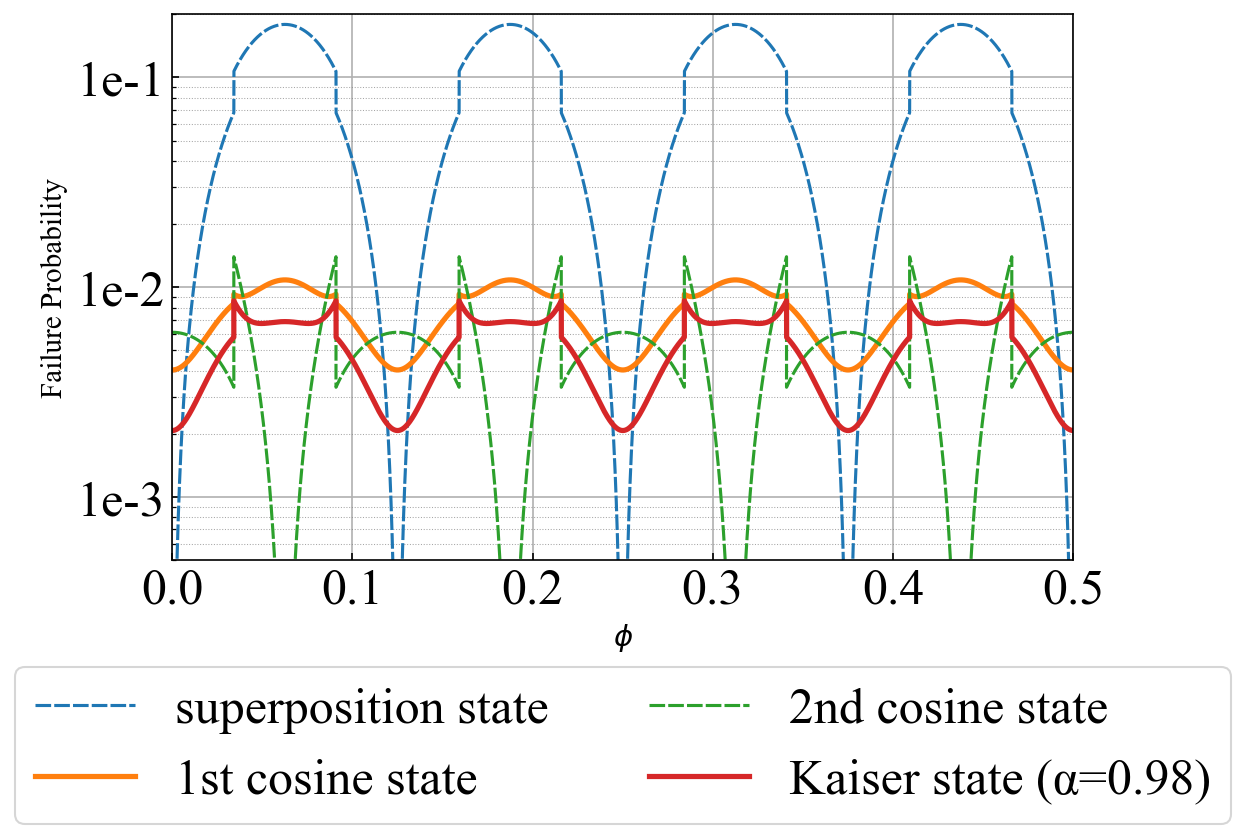

In [80]:
import matplotlib.ticker as ticker
from matplotlib.ticker import LogLocator, NullFormatter, LogFormatterExponent
a = 1.4

a = 1.4
fig, ax = plt.subplots(figsize=(a*6, a*4.5), dpi=150)
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.direction'] = 'in'#x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['ytick.direction'] = 'in'

plt.rcParams["font.family"] = "Times New Roman"   # 

plt.plot(phi_values, failure_sp_values, linestyle=((0, (5, 1))), linewidth = 1.5, label="superposition state")
plt.plot(phi_values, failure_sin_values,  linewidth = 2.5, label="1st cosine state")
plt.plot(phi_values, failure_cos_values,  linestyle=((0, (5, 1))),  linewidth = 1.5,label="2nd cosine state")
plt.plot(phi_values, failure_kaiser_values,  linewidth = 2.5, label="Kaiser state (α={})".format(alpha))

# plt.plot(phi_values, failure_sp_values,  linewidth = 1.5, label="superposition state")
# plt.plot(phi_values, failure_sin_values,  linewidth = 3, label="1st cos state")
# plt.plot(phi_values, failure_cos_values,  linewidth = 1.5,label="2nd cos state")
# plt.plot(phi_values, failure_kaiser_values,  linewidth = 3, label="Kaiser state (α={})".format(alpha))


ax.set_yscale('log')
ax.set_xlabel(r"$\phi$", fontsize=14)
ax.set_ylabel("Failure Probability", fontsize=14)
ax.set_xlim([0, 0.5])
ax.set_ylim([0.5e-3, 0.2])

# ax.set_ylim([0.5e-3, 2e-2])
# ax.set_title(r"Failure Probability vs. $\phi$ (p={})".format(p), fontsize=16)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(
    lambda y, _: f'1e{int(np.log10(y))}' if y > 0 else ''))

# グリッド設定（メジャー・マイナーとも）
ax.grid(True, which='major', linestyle="solid", linewidth=0.8)
# ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(1.0, 10.0), numticks=20))
# ax.xaxis.set_minor_formatter(NullFormatter())
ax.grid(True, which='minor', color="gray", linestyle=":", linewidth=0.5, alpha=0.7)


ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

plt.tight_layout()
# plt.show()

plt.savefig("Probe_paper.pdf")

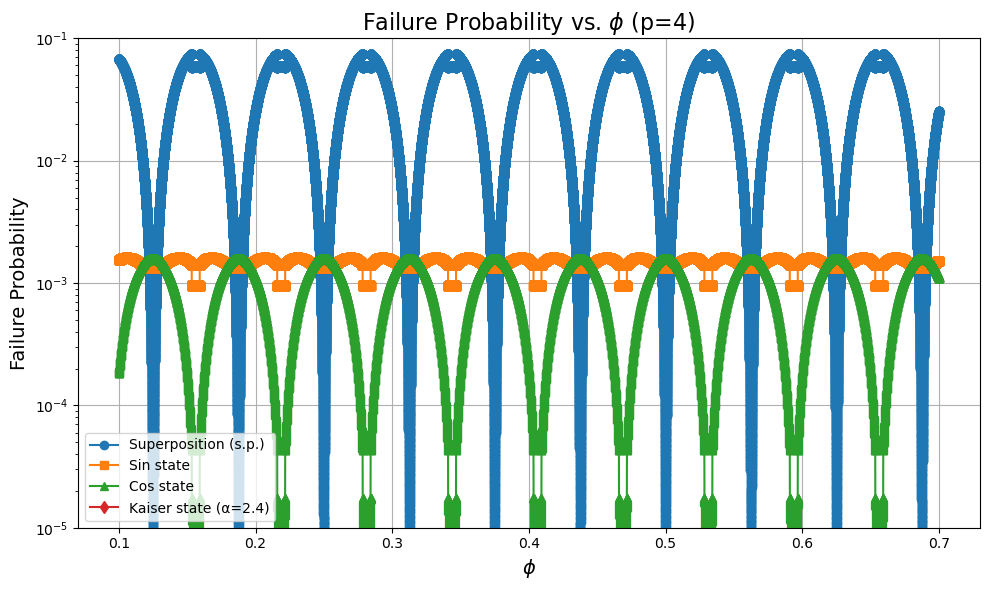

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import i0

# ----- パラメータの設定 -----
p = 4               # 例として p = 3
alpha = 2.40       # Kaiser状態のパラメータ
N = 2**p            # 測定基底のサイズ

# ν の取りうる値の集合: ν ∈ { -(2^p-1), -(2^p-3), ..., 2^p-3, 2^p-1 }
nus = np.arange(-(2**p - 1), 2**p, 2)
# 例: p=3 の場合, nus = [-7, -5, -3, -1, 1, 3, 5, 7]

# ----- 各状態の係数の定義 -----

# (1) Superposition state (s.p.)
def c_nu_sp(nu, p):
    return 1/np.sqrt(2**p)

# (2) Sin state
def c_nu_sin(nu, p):
    # 定義に従う (ここでは問題文の式をそのまま使用)
    # return (np.sqrt(2) / np.sqrt(2**p + 1)) * np.sin(((nu + 9) * np.pi) / (2 * (2**p + 1)))
    return (np.sqrt(2) / np.sqrt(2**p + 1)) * np.cos(((nu) * np.pi) / (2 * (2**p + 1)))

# (3) Cos state
def c_nu_cos(nu, p):
    return (np.sqrt(2) / np.sqrt(2**p)) * np.cos((np.pi * nu) / (2**(p+1)))

# (4) Kaiser state
def c_nu_kaiser(nu, p, alpha):
    return (1 / (2**p)) * ( i0(np.pi * alpha * np.sqrt(1 - (nu/(2**p))**2)) / i0(np.pi * alpha) )

# ----- 各状態の c_nu の計算 -----
c_sp     = np.array([ c_nu_sp(nu, p) for nu in nus ])
c_sin    = np.array([ c_nu_sin(nu, p) for nu in nus ])
c_cos    = np.array([ c_nu_cos(nu, p) for nu in nus ])
c_kaiser = np.array([ c_nu_kaiser(nu, p, alpha) for nu in nus ])
c_kaiser = 1/ np.sqrt(np.sum(c_kaiser**2)) * c_kaiser

# ----- 振幅 A(k) の計算関数 -----
def A_k(k, phi, p, nus, c_nus):
    """
    与えられた状態の係数 c_nus を用いて，
    A(k)= (1/sqrt(2^p)) * Σ_{ν∈N} c_nus * exp[2π i (φ - k/2^p) ν]
    を計算する．
    """
    phase_factors = np.exp(2 * np.pi * 1j * (phi - k/2**p) * (nus + 7)/2 )
    return 1/np.sqrt(2**p) * np.sum(c_nus * phase_factors)

# ----- 各状態に対して P(k|phi) の計算と失敗確率の求め方 -----
def compute_failure_probability(c_nus, p, phi):
    """
    与えられた c_nus（状態の係数配列）に対して，
    各 k に対する振幅 A(k) および確率 P(k|phi)=|A(k)|^2 を計算し，
    条件 |k/2^p - φ| > 1/(2π) を満たす k の P(k|phi) の和を失敗確率として返す．
    """
    N = 2**p
    P = np.zeros(N)
    for k in range(N):
        amplitude = A_k(k, phi, p, nus, c_nus)
        P[k] = np.abs(amplitude)**2
    # 条件を満たす k のインデックスの集合 A
    A_indices = [k for k in range(N) if abs(k/2**p - phi) > 1/(2*np.pi)]
    failure_probability = np.sum(P[A_indices])
    return failure_probability

# ----- φ を変化させたときの失敗確率の計算 -----
phi_values = np.linspace(0.1, 0.7, 100000, endpoint=False)
failure_sp_values     = np.array([ compute_failure_probability(c_sp, p, phi) for phi in phi_values ])
failure_sin_values    = np.array([ compute_failure_probability(c_sin, p, phi) for phi in phi_values ])
failure_cos_values    = np.array([ compute_failure_probability(c_cos, p, phi) for phi in phi_values ])
failure_kaiser_values = np.array([ compute_failure_probability(c_kaiser, p, phi) for phi in phi_values ])

# ----- 結果のプロット -----
plt.figure(figsize=(10,6))
plt.plot(phi_values, failure_sp_values, 'o-', label="Superposition (s.p.)")
plt.plot(phi_values, failure_sin_values, 's-', label="Sin state")
plt.plot(phi_values, failure_cos_values, '^-', label="Cos state")
plt.plot(phi_values, failure_kaiser_values, 'd-', label="Kaiser state (α={})".format(alpha))
plt.yscale('log')
plt.xlabel(r"$\phi$", fontsize=14)
plt.ylabel("Failure Probability", fontsize=14)
plt.ylim([10**-5, 10**-1])
plt.title(r"Failure Probability vs. $\phi$ (p={})".format(p), fontsize=16)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


2.5966142084830927e-06 0.0016170078516551346 0.001609419075116815


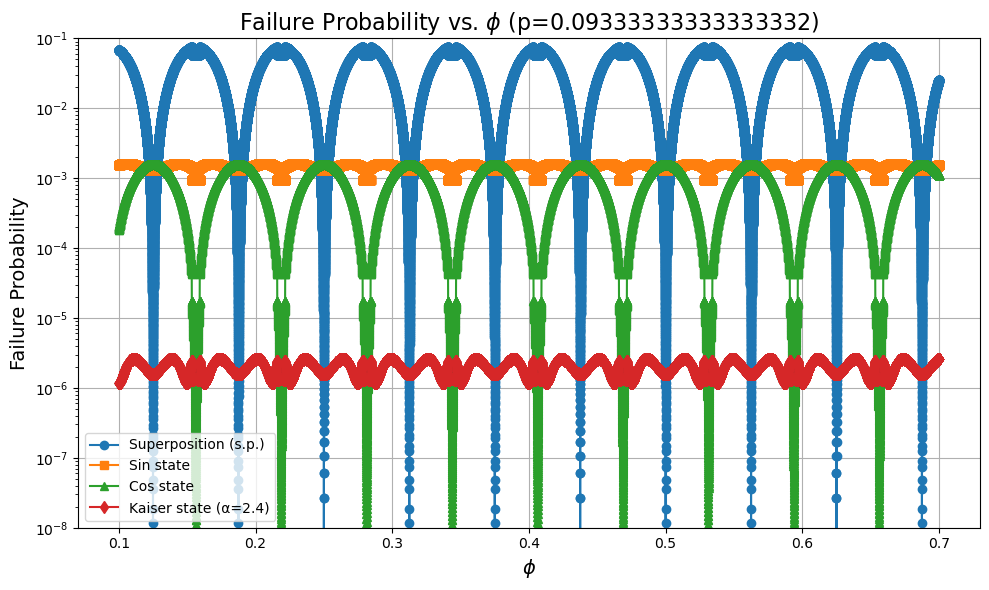

In [17]:
print(max(failure_kaiser_values), max(failure_sin_values), max(failure_cos_values))

plt.figure(figsize=(10,6))
plt.plot(phi_values, failure_sp_values, 'o-', label="Superposition (s.p.)")
plt.plot(phi_values, failure_sin_values, 's-', label="Sin state")
plt.plot(phi_values, failure_cos_values, '^-', label="Cos state")
plt.plot(phi_values, failure_kaiser_values, 'd-', label="Kaiser state (α={})".format(alpha))
plt.yscale('log')
plt.xlabel(r"$\phi$", fontsize=14)
plt.ylabel("Failure Probability", fontsize=14)
plt.ylim([10**-8, 10**-1])
plt.title(r"Failure Probability vs. $\phi$ (p={})".format(p), fontsize=16)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
import math
from matplotlib.ticker import MaxNLocator

import math
from scipy.stats import binom
import numpy as np
import matplotlib.pyplot as plt

In [19]:
import numpy as np

p = 2
alpha =  0.6

def compute_even_moments(k_max, p = 4):
    # S の定義
    S = np.arange(-(2**p - 1), 2**p, 2)
    # 結果を格納する辞書
    moments = {}
    # c_kaiser    = np.array([ c_nu_sin(nu, p) for nu in S ])

    c_kaiser = np.array([ c_nu_kaiser(nu, p, alpha) for nu in nus ])
    c_kaiser = 1/ np.sqrt(np.sum(c_kaiser**2)) * c_kaiser 
    
    # k=0 から k_max まで計算（ここで偶数次モーメントは 2k 乗）
    # for k in range(0, k_max + 1):
    #     # 各項の計算: ν^(2k) * sin^2(((ν+9)*π/18))
    #     moment =  (2/9) * np.sum( (S/8)**(2*k) * np.sin((S + 9) * np.pi / 18)**2 )
    #     moments[2*k] = moment
    # return moments

    for k  in range(0, k_max + 1):
        # 各項の計算: ν^(2k) * sin^2(((ν+9)*π/18))
        moment =   np.sum( (S/2**p)**(2*k) * c_kaiser**2 )
        moments[2*k] = moment
    return moments




    # 例として k_max=5 (すなわち 0,2,4,6,8,10 次モーメント)
k_max = 5
moments = compute_even_moments(k_max,2)

for exp, moment in sorted(moments.items()):
    print(f"E[X^{exp}] = {moment:.6f}")


# パラメータの設定
p = 0.32 + 1/12
L = 1000

def get_maxK_above_prob(target_prob, p=p, L=L):
    """
    Binom(K, p) において，X >= ceil(K/2) となる確率が target_prob より大きい
    最大の偶数 K (2 <= K < L) を返す関数．
    
    Parameters:
      target_prob: 判定したい確率の閾値
      p: 各試行の成功確率 (デフォルトは 0.01+1/12)
      L: K の探索上限 (デフォルトは300)
    
    Returns:
      条件を満たす最大の偶数 K．条件を満たす K が存在しない場合は None．
    """
    best_K = None
    # K は 2 から L 未満の偶数を走査
    for K in range(2, L, 2):
        x_min = math.floor((K+1) / 2)
        current_prob = binom.sf(x_min - 1, K, p)  # P(X >= x_min)
        if current_prob > target_prob:
            best_K = K
        else:
            # 条件を満たさなくなったらループを終了
            break
    return best_K

#0.01651
#0.0643 Kaiser 

E[X^0] = 1.000000
E[X^2] = 0.228786
E[X^4] = 0.107835
E[X^6] = 0.059354
E[X^8] = 0.033305
E[X^10] = 0.018729


In [20]:
# def min_q(t,eps):
#     query = int(t)
#     log_q_fact = 0
#     for i in range(query):
#         log_q_fact += np.log(i+1)
#     while True:
#         query += 1
#         log_q_fact += np.log(query)
#         if (np.log(4)+query*np.log(t)-query*np.log(2)-log_q_fact) <= np.log(eps):
#             break

#     return query

def min_q(t,eps):
    
    def cost(q,t,eps):
        """\
        if q is too small, this cost is positive
        """
        q = float(q)
        t = float(t)
#         log_q_fact = 0
#         for i in range(q):
#             log_q_fact += np.log(i+1)
        log_q_fact = q*np.log(q)-q
        return np.log(4)+q*np.log(t)-q*np.log(2)-log_q_fact - np.log(eps) 
    
    #print(t)
    query = int(t)
    query_low = int(t)
    
    ### search upper bound
    while True:
        query = 2*query
        if cost(query,t,eps) < 0:
            break
    
    query_upp = copy.deepcopy(query)
#     print("query_upper")
#     print(query_upp)
#     print("cost")
#     print(cost(query_upp,t,eps))
#     print("query_mid")
    
    while True:
        query_mid = int(np.ceil((query_upp+query_low)/2))
#         print(query_mid)
#         print(cost(query_mid,t,eps))
#         print("")
        if cost(query_mid,t,eps) >= 0:
            query_low = query_mid
        else:
            query_upp = query_mid
            
        if query_mid == int(np.ceil((query_upp+query_low)/2)):
            break
    
    return int(np.ceil((query_upp+query_low)/2))

def lem8_sp_query(q,M,qubits):
    p = 3
    eps_double = 2**(-14)
    delta = 2**(-10)
    sigma = int(np.ceil(np.sqrt(2*M*(qubits*np.log(2)+np.log(2/delta)))))
    t = (2**(p+q+2))*sigma
    
    query = 4*(-1+min_q(t,eps_double/8))
    
    ### berry HS
    # query = 2*(-1+min_q(t,eps_double/8))
    
#     ### grover
#     query = t
    
    return query


def imp_sp_query_sym(q, N, eta, k, target_precision, c):
    p = 3
    eps_double = 2**(-14)
    v =  0.1652
    norm = math.comb(eta, k) * math.comb((N-eta +k ), k )
    M = math.comb(N, k) ** 2
    delta = 2**(-10)
    dim = math.comb(N, eta)
    errp = c/(8**(int(np.ceil(np.log2(1/target_precision)))-q))

    sigma =  int(np.ceil(np.sqrt(2 *  v *  norm *(np.log(2*dim /delta) )  ) + 4/3 *np.log(2*dim /delta) ) ) 
    
    # sigma =   int(np.ceil(np.sqrt(2* M* np.ceil(8*np.log(M/errp)) )))
    
    t = (2**(p+q) * 2  )*sigma
    # print(M/errp)
    prob = 0.011 + 1/12
    L = 1000
    rep = get_maxK_above_prob(errp/M, p=prob, L=L)
    # print(rep)
    # query = 2*t * rep
    
    # return query
    #query = 4*(-1+min_q(t,eps_double/8))
    
    ### berry HS
    query = 2*(-1+min_q(t,eps_double/8)) * rep
    return query

def imp_sp_query_sym2(q, N, eta, k, target_precision, c):
    p = 3
    eps_double = 2**(-14)
    v = 0.154
    norm = math.comb(eta, k) * math.comb((N-eta +k ), k )
    M = math.comb(N, k) ** 2
    delta = 2**(-10)
    dim = math.comb(N, eta)
    errp = c/(8**(int(np.ceil(np.log2(1/target_precision)))-q))

    sigma =  int(np.ceil(np.sqrt(2 *  v *  norm *(np.log(2*dim /delta) )  ) + 4/3 *np.log(2*dim /delta) ) ) 
    
    # sigma =   int(np.ceil(np.sqrt(2* M* np.ceil(8*np.log(M/errp)) )))
    
    t = (2**(p+q) * 2  )*sigma
    # print(M/errp)
    prob = 0.009 + 1/12
    L = 1000
    rep = get_maxK_above_prob(errp/M, p=prob, L=L)
    # print(rep)
    # query = 2*t * rep
    
    # return query
    #query = 4*(-1+min_q(t,eps_double/8))
    
    ### berry HS
    query = 2*(-1+min_q(t,eps_double/8)) * rep
    return query


def imp_sp_query_int(q, N, eta, k, target_precision, c):
    p = 3
    eps_double = 2**(-14)
    v =  0.163
    norm = math.comb(eta, k) * math.comb((N-eta +k ), k )
    M = math.comb(N, k) ** 2
    delta = 2**(-10)
    dim = math.comb(N, eta)
    eps_double = 2**(-14)

    delta = 2**(-10)
    
    errp = c/(8**(int(np.ceil(np.log2(1/target_precision)))-q))
    Error =  errp/2

    delta = min( Error**2 / 20, delta)
    eps_double = min(eps_double, Error**2 / 2**6)

    prob = 0.011
    L = 1000
    rep = get_maxK_above_prob(errp/(2*M), p=prob, L=L)
    sigma = int(np.ceil(np.sqrt(2 *  v * rep*  norm *(np.log(2*dim /delta) )  ) + 4/3 *np.log(2*dim /delta) ) ) 
    # sigma =  int(np.ceil(np.sqrt(2 *  M*(np.log(2*dim /delta) ) * np.ceil(9*np.log(M/errp) ) ) ) ) 
    
    # sigma =   int(np.ceil(np.sqrt(2* M* np.ceil(8*np.log(M/errp)) )))
    
    t = (2**(p+q) * 2  )*sigma
    
    #query = 4*(-1+min_q(t,eps_double/8))
    
    ### berry HS
    query = 2*(-1+min_q(t,eps_double/8))
    
#     ### grover
    # query = 2*t
    
    return query

def imp_sp_query_int2(q, N, eta, k, target_precision, c):
    p = 2
    eps_double = 2**(-14)
    v =   0.22
    norm = math.comb(eta, k) * math.comb((N-eta +k ), k )
    M = math.comb(N, k) ** 2
    delta = 2**(-10)
    dim = math.comb(N, eta)
    eps_double = 2**(-14)

    delta = 2**(-10)
    
    errp = c/(8**(int(np.ceil(np.log2(1/target_precision)))-q))
    Error =  errp/2

    delta = min( Error**2 / 20, delta)
    eps_double = min(eps_double, Error**2 / 2**6)

    prob = 0.32
    L = 1000
    rep = get_maxK_above_prob(errp/(2*M), p=prob, L=L)
    sigma = int(np.ceil(np.sqrt(2 *  v * rep*  norm *(np.log(2*dim /delta) )  ) + 4/3 *np.log(2*dim /delta) ) ) 
    # sigma =  int(np.ceil(np.sqrt(2 *  M*(np.log(2*dim /delta) ) * np.ceil(9*np.log(M/errp) ) ) ) ) 
    
    # sigma =   int(np.ceil(np.sqrt(2* M* np.ceil(8*np.log(M/errp)) )))
    
    t = (2**(p+q) * 2  )*sigma
    
    #query = 4*(-1+min_q(t,eps_double/8))
    
    ### berry HS
    query = 2*(-1+min_q(t,eps_double/8))
    
#     ### grover
    # query = 2*t
    
    return query




# eps = 10**(-2)
# eps2 = 10**(-4)
# t = [j+1 for j in range(10**2)]
# Q = [min_q(j, eps)-1 for j in t] 
# Q2 = [min_q(j, eps2)-1 for j in t] 
# plt.plot(t,Q, label="10-2")
# plt.plot(t,Q2, label="10-4")
# plt.plot(t,t, label="t")
# plt.legend()

In [21]:
import math
def total_query(target_precision, N, eta, k, c=3/(8*((1+np.pi)**2))):
    M = math.comb(N,k) **2
    qubits = N
    tot_query = 0
    for q in range(int(np.ceil(np.log2(1/target_precision)))+1):
        errp = c/(8**(int(np.ceil(np.log2(1/target_precision)))-q))
        tot_query += int(np.ceil(9*np.log(M/errp)))*lem8_sp_query(q,M,qubits)
        
    return tot_query

def imp_total_query_sym(target_precision, N, eta, k,  c=1/(8*((1+np.pi)**2))):
    tot_query = 0
    a = np.sqrt(2)
    for q in range(int(np.ceil(np.log2(1/target_precision /a )))+1):
        # errp = c/(8**(int(np.ceil(np.log2(1/target_precision)))-q))
        tot_query += imp_sp_query_sym(q, N, eta, k, a* target_precision, c)
        
    return tot_query

def imp_total_query_int(target_precision, N, eta, k,  c=1/(8*((1+np.pi)**2))):
    tot_query = 0
    a = np.sqrt(2)
    for q in range(int(np.ceil(np.log2(1/target_precision / a)))+1):
        # errp = c/(8**(int(np.ceil(np.log2(1/target_precision)))-q))
        tot_query += imp_sp_query_int(q, N, eta, k, a*target_precision, c)
        
    return tot_query

def imp_total_query_sym2(target_precision, N, eta, k,  c=1/(8*((1+np.pi)**2))):
    tot_query = 0
    a = np.sqrt(2)
    for q in range(int(np.ceil(np.log2(1/target_precision /a )))+1):
        # errp = c/(8**(int(np.ceil(np.log2(1/target_precision)))-q))
        tot_query += imp_sp_query_sym2(q, N, eta, k, a* target_precision, c)
        
    return tot_query

def imp_total_query_int2(target_precision, N, eta, k,  c=1/(8*((1+np.pi)**2))):
    tot_query = 0
    a = np.sqrt(2)
    for q in range(int(np.ceil(np.log2(1/target_precision / a)))+1):
        # errp = c/(8**(int(np.ceil(np.log2(1/target_precision)))-q))
        tot_query += imp_sp_query_int2(q, N, eta, k, a*target_precision, c)
        
    return tot_query






    




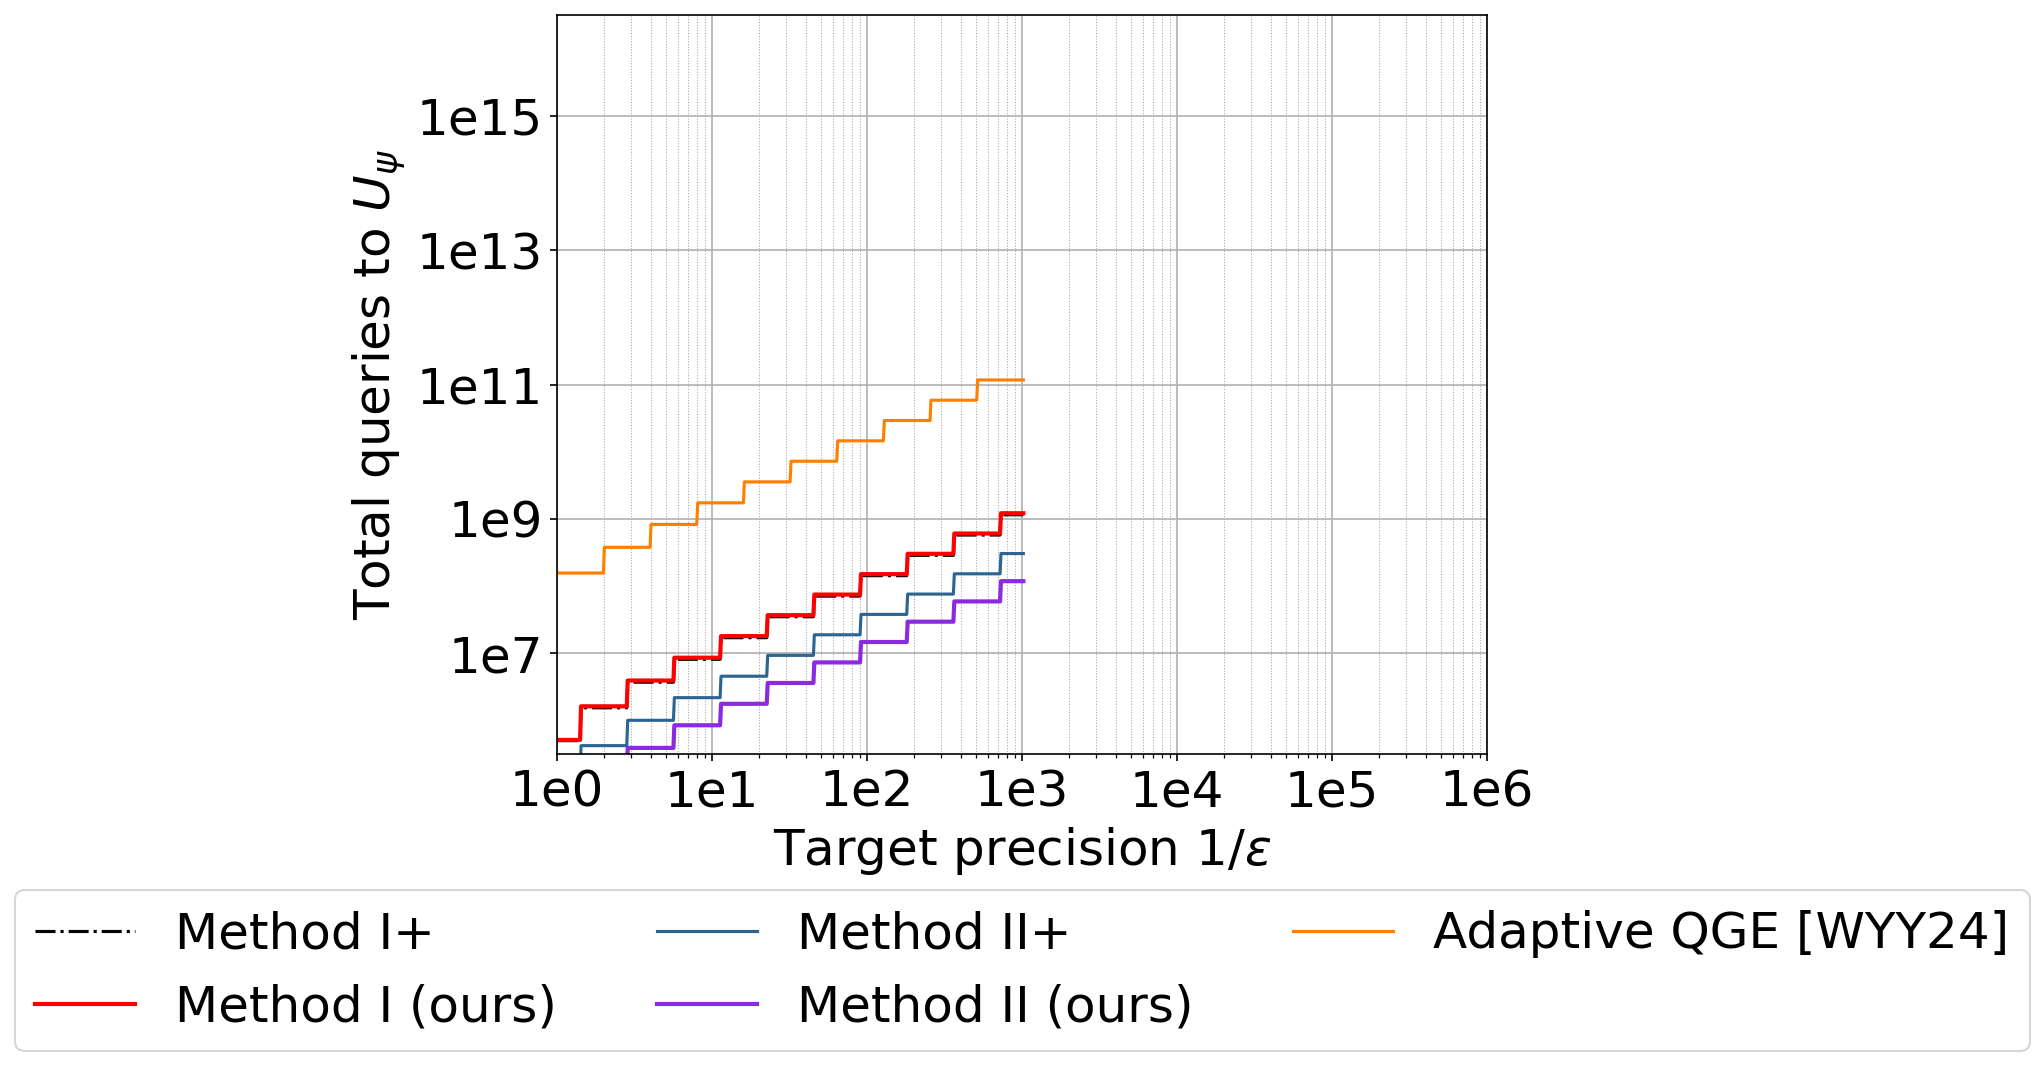

In [23]:
import matplotlib.ticker as ticker
from matplotlib.ticker import LogLocator, NullFormatter, LogFormatterExponent
dpi = 150
# dpi = 100
# fig, ax = plt.subplots(figsize=(4,2), dpi=dpi)
a = 1.6
# fig, ax = plt.subplots(figsize=(a*3, a*4.5), dpi=dpi)
fig, ax = plt.subplots(figsize=(5*a, 4*a), dpi=dpi)
plt.rcParams["font.size"] = 24

k = 1
N =  152
num_particle =  113 #int(qubits * 7/8)
eta = 113


target_precision = [2**(-0.01*j) for j in range(1, 1000, 2)]
target_inv_eps = [1/j for j in target_precision]

a=1
# # Z = 0.45 
if a == 1:
    tot_query = [ total_query(j, N, eta, k) for j in target_precision]
    sym_tot_query = [imp_total_query_sym(j, N, eta, k) for j in target_precision]
    int_tot_query = [imp_total_query_int(j, N, eta, k) for j in target_precision]
    sym_tot_query2 = [imp_total_query_sym2(j, N, eta, k) for j in target_precision]
    int_tot_query2 = [imp_total_query_int2(j, N, eta, k) for j in target_precision]



# 各プロットにカラーパレットを指定
# ax.plot(target_inv_eps, tot_query_CS,    color="#000000", linestyle="-.", label="[ZRM21]")      # 紫 (暗め)
# ax.plot(target_inv_eps, sym_tot_query,  color="red", linewidth = 2,label="Method I (ours)")  # 青 (暗め)
# ax.plot(target_inv_eps, tot_query_HLQAE, color="#2C6493", linewidth = 1.5,   label="HL QAE")
# ax.plot(target_inv_eps, int_tot_query,  color="#8A2BE2", linewidth = 2,label="Method III (ours)")
# ax.plot(target_inv_eps, tot_query,       color="#FF7F00", linewidth = 1.5, label="[WYY24]")

ax.plot(target_inv_eps, sym_tot_query2,    color="#000000", linestyle="-.", label="Method I+")      # 紫 (暗め)
ax.plot(target_inv_eps, sym_tot_query,  color="red", linewidth = 2,label="Method I (ours)")  # 青 (暗め)
ax.plot(target_inv_eps, int_tot_query2, color="#2C6493", linewidth = 1.5,   label="Method II+")
ax.plot(target_inv_eps, int_tot_query,  color="#8A2BE2", linewidth = 2,label="Method II (ours)")
ax.plot(target_inv_eps, tot_query,       color="#FF7F00", linewidth = 1.5, label="Adaptive QGE [WYY24]")

# 
ax.set_yscale("log")
ax.set_xscale("log")
scale_factor = 1e10
ax.minorticks_on()

ax.set_ylabel(r'Total queries to $U_{\psi}$')
ax.set_xlabel(r'Target precision $1/\varepsilon$')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(
    lambda y, _: f'1e{int(np.log10(y))}' if y > 0 else ''))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(
    lambda y, _: f'1e{int(np.log10(y))}' if y > 0 else ''))


ax.set_xlim([10**(-0.), 10**6.])
ax.set_ylim([10**(5.5), 10**16.5])
ax.xticks = [1, 10,100,1000,1e4, 1e5,1e6]
# ax.legend(facecolor="white", framealpha=1, frameon=True, loc=2, markerfirst=False, fontsize=8)

# ax.legend(loc="lower right", facecolor="white", framealpha=1, frameon=True, markerfirst=False, fontsize=8)
# ax.minorticks_on()


# ax.grid()
ax.grid(linestyle = 'solid', linewidth = 0.5)
ax.grid(which="minor", color="lightgray", linestyle="dotted")

# ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(1.0, 10.0), numticks=20))
ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(1.0, 10.0), numticks=20))
ax.xaxis.set_minor_formatter(NullFormatter())


# マイナーティックをはっきり表示するためのスタイルを調整（少し目立つように変更）
ax.grid(which="minor", color="gray", linestyle=":", linewidth=0.5, alpha=0.7)

# メジャーグリッド（そのまま）
ax.grid(which="major", linestyle="solid", linewidth=0.8)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)


# plt.show()

# fig.savefig("2025-03-20-3RDM-long.pdf", bbox_inches='tight')

In [94]:
np.average(np.array(int_tot_query)/np.array(int_tot_query2))**-1
np.average(np.array(int_tot_query)/np.array(int_tot_query2))**-1

3.2165854366898095